In [1]:
import os,sys,time,copy
import random
import numpy as np
import pandas as pd
from scipy import interpolate
from scipy.integrate import fixed_quad,quad 
from tqdm import tqdm

import mpmath
from mpmath import fp

#--matplotlib
import matplotlib
from matplotlib.lines import Line2D
matplotlib.rcParams['text.latex.preamble']=r"\usepackage{amsmath}"
matplotlib.rc('text',usetex=True)
import pylab as py
from matplotlib import colors
import matplotlib.gridspec as gridspec

#--torch
import torch
import torch.nn as nn
import torch.optim as optim

print(torch.cuda.is_available())
torch.cuda.empty_cache()
manualSeed = 999 # Set random seed for reproducibility
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)
#torch.use_deterministic_algorithms(True) # Needed for reproducible results
#! Number of GPUs available. Use 0 for CPU mode.
ngpu = 1 
#! Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")


False
Random Seed:  999


In [17]:
from scipy.special import gamma,zeta,jv,jn_zeros,kv
from scipy.interpolate import griddata,RegularGridInterpolator,CubicSpline

sys.path.insert(0,'sidis')

import sidis.qcdlib.params as params
import sidis.qcdlib.cfg as cfg
from sidis.qcdlib.alphaS  import ALPHAS
from sidis.qcdlib.alphaS_dev  import ALPHAS as ALPHAS_DEV
from sidis.qcdlib.eweak   import EWEAK
from sidis.qcdlib.mellin import MELLIN
from sidis.qcdlib import special


from qcf.qcd_qcf_1d import PDF
from qcf.qcd_ff_1d import FF_PIP

In [5]:
mellin = MELLIN()
alphaS = ALPHAS()
pdf = PDF(mellin,alphaS)
ff = FF_PIP(mellin,alphaS)

In [6]:
X = 10**np.linspace(-4,0,100)
Q2 = 10.0

uv = []
dv = []
g = []
for x in X:
    uv.append(pdf.get_xF(x,Q2,'uv'))
    dv.append(pdf.get_xF(x,Q2,'dv'))
    g.append(pdf.get_xF(x,Q2,'g'))
uv = np.array(uv)
dv = np.array(dv)
g = np.array(g)

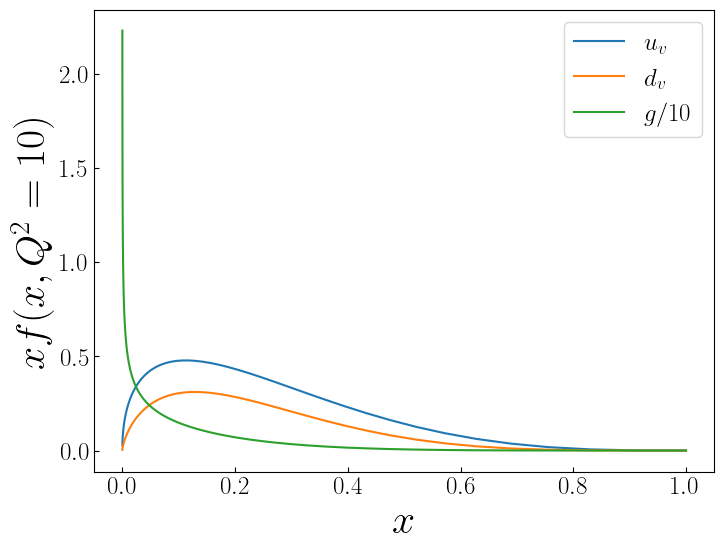

In [7]:
nrows,ncols=1,1
py.figure(figsize=(8*ncols,6*nrows))
ax=py.subplot(nrows,ncols,1)

ax.plot(X,uv,label=r'$u_v$')
ax.plot(X,dv,label=r'$d_v$')
ax.plot(X,g/10,label=r'$g/10$')
ax.legend(fontsize=18)
# ax.semilogx()
ax.set_xlabel(r'$x$',size=30)
ax.set_ylabel(r'$xf(x,Q^2=10)$',size=30)
ax.tick_params(direction='in',labelsize=18,which='both',axis='both')


In [21]:
class MODEL:
    
    def __init__(self):
        #--params
        euler=special.euler

        self.Q0 = np.sqrt(cfg.Q20)
        self.C1=2*np.exp(-euler)
        self.C2=1
        
        self.bmax = self.C1/self.Q0 #--so that mub > mu_0
    
    #============================================================
    #--Defining functions associated with bstar
    #============================================================
    #--typical logarithm in perturbative expansions
    def get_Log(self,bT,mu):  
        """
        Typical log in the expansion
        """
        return np.log(mu*bT/self.C1)

    #--Setting up b_*
    def get_bstar(self,bT):
        """
        Returns b*
        """
        return bT/np.sqrt(1+bT**2/self.bmax**2)

    def get_bmin(self,Q):
        """
        Returns bmin
        """
        return self.C1/Q

    #--Setting up b_* a la MAP
    def get_bstar_MAP(self,bT,Q):
        """
        Returns b*
        """
        bmax = self.bmax
        bmin = self.get_bmin(Q)
        return bmax * ((1 - np.exp(-bT**4 / bmax**4)) / (1 - np.exp(-bT**4 / bmin**4)))**(0.25)

    def get_mub(self,bT): 
        """
        Returns mub* 
        """
        return self.C1/self.get_bstar(bT)

    def get_mub_MAP(self,bT,Q): 
        """
        Returns mub* a la MAP
        """
        return self.C1/self.get_bstar_MAP(bT,Q)



In [22]:
tmdmodel = MODEL()

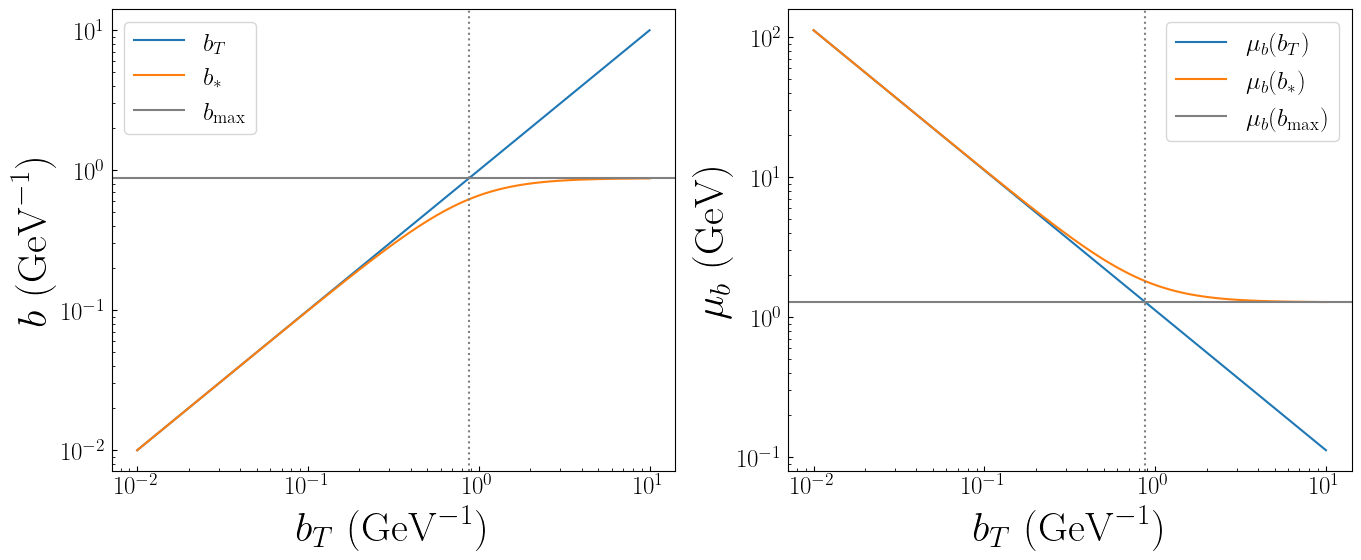

In [23]:
nrows,ncols = 1,2
py.figure(figsize=(8*ncols,6*nrows))

bT = 10**np.linspace(-2,1,100)

bstar = tmdmodel.get_bstar(bT)

mubstar = tmdmodel.get_mub(bT)
mu_nobstar = tmdmodel.C1 / bT

ax=py.subplot(nrows,ncols,1)
ax.plot(bT,bT,label=r'$b_T$')
ax.plot(bT,bstar,label=r'$b_*$')
ax.axvline(x=tmdmodel.bmax,ls=':',c='grey')
ax.axhline(y=tmdmodel.bmax,c='grey',label=r'$b_{\rm max}$')
ax.tick_params(direction='in',labelsize=18,axis='both',which='both')
# ax.set_xlim(0,2)
# ax.set_ylim(0,2)
ax.set_ylabel(r'$b~({\rm GeV}^{-1})$',size=30)
ax.loglog()
ax.legend(fontsize=18)
ax.set_xlabel(r'$b_T~({\rm GeV}^{-1})$',size=30)

ax=py.subplot(nrows,ncols,2)
ax.plot(bT,mu_nobstar,label=r'$\mu_b(b_T)$')
ax.plot(bT,mubstar,label=r'$\mu_b(b_*)$')
ax.axvline(x=tmdmodel.bmax,ls=':',c='grey')
ax.axhline(y= tmdmodel.C1 / tmdmodel.bmax,ls='-',c='grey',label=r'$\mu_b(b_{\rm max})$')
ax.tick_params(direction='in',labelsize=18,axis='both',which='both')
ax.semilogx()
ax.semilogy()
ax.set_xlabel(r'$b_T~({\rm GeV}^{-1})$',size=30)
ax.set_ylabel(r'$\mu_b~({\rm GeV})$',size=30)
ax.legend(fontsize=18)


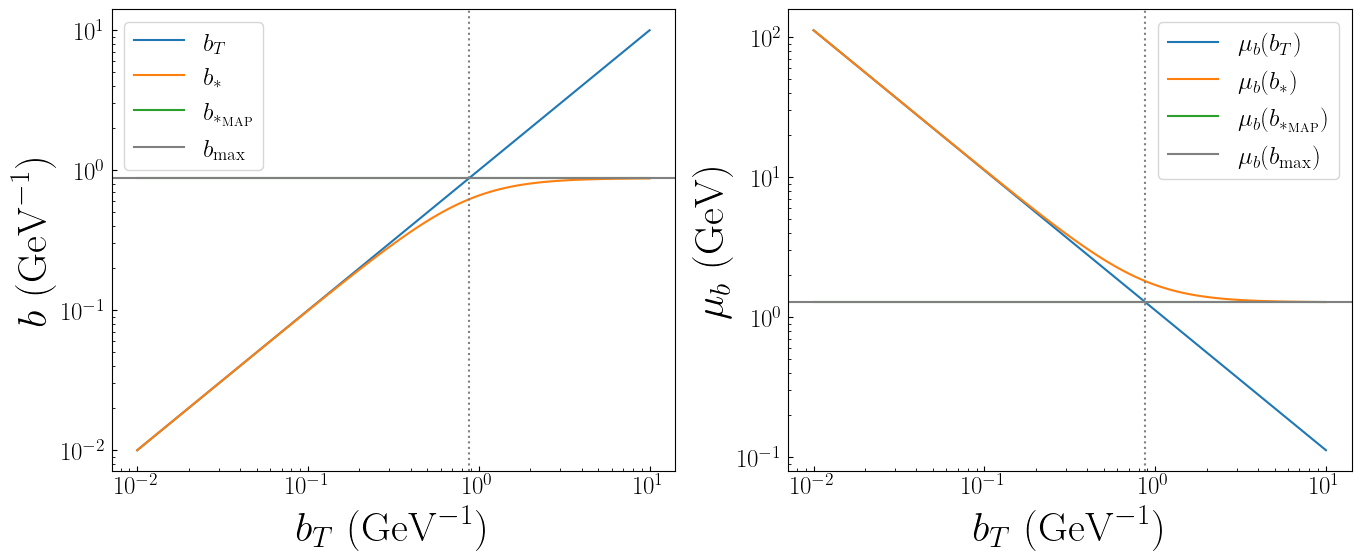

In [24]:
nrows,ncols = 1,2
py.figure(figsize=(8*ncols,6*nrows))

bT = 10**np.linspace(-2,1,100)
Q = tmdmodel.Q0
bstar = tmdmodel.get_bstar(bT)
bstar_MAP = tmdmodel.get_bstar_MAP(bT,Q)

mubstar = tmdmodel.get_mub(bT)
mubstar_MAP = tmdmodel.get_mub_MAP(bT,Q)
mu_nobstar = tmdmodel.C1 / bT

ax=py.subplot(nrows,ncols,1)
ax.plot(bT,bT,label=r'$b_T$')
ax.plot(bT,bstar,label=r'$b_*$')
ax.plot(bT,bstar_MAP,label=r'$b_{*_{\rm MAP}}$')
ax.axvline(x=tmdmodel.bmax,ls=':',c='grey')
ax.axhline(y=tmdmodel.bmax,c='grey',label=r'$b_{\rm max}$')
ax.tick_params(direction='in',labelsize=18,axis='both',which='both')
# ax.set_xlim(0,2)
# ax.set_ylim(0,2)
ax.set_ylabel(r'$b~({\rm GeV}^{-1})$',size=30)
ax.loglog()
ax.legend(fontsize=18)
ax.set_xlabel(r'$b_T~({\rm GeV}^{-1})$',size=30)

ax=py.subplot(nrows,ncols,2)
ax.plot(bT,mu_nobstar,label=r'$\mu_b(b_T)$')
ax.plot(bT,mubstar,label=r'$\mu_b(b_*)$')
ax.plot(bT,mubstar_MAP,label=r'$\mu_b(b_{*_{\rm MAP}})$')
ax.axvline(x=tmdmodel.bmax,ls=':',c='grey')
ax.axhline(y= tmdmodel.C1 / tmdmodel.bmax,ls='-',c='grey',label=r'$\mu_b(b_{\rm max})$')
ax.tick_params(direction='in',labelsize=18,axis='both',which='both')
ax.semilogx()
ax.semilogy()
ax.set_xlabel(r'$b_T~({\rm GeV}^{-1})$',size=30)
ax.set_ylabel(r'$\mu_b~({\rm GeV})$',size=30)
ax.legend(fontsize=18)


In [25]:
class PDF_OPE:
    
    def __init__(self,pdf):

        self.iorder = cfg.tmd_order #--LO: 0, NLO: 1
        
        self.pdf = pdf
        self.mellin = pdf.mellin
        
        self.tmdmodel=tmdmodel
        self.alphaS=alphaS
        
        self.CF=params.CF
        self.CA=params.CA
        self.TR=params.TR
        self.TF=params.TF
        
        #--set_charges
        quarkcharges = np.zeros(11)
        quarkcharges[0] = 0 # gluon
        quarkcharges[1] = 2/3 # u
        quarkcharges[2] =-1/3 # d
        quarkcharges[3] =-1/3 # s
        quarkcharges[4] = 2/3 # c
        quarkcharges[5] =-1/3 # b

        quarkcharges[-1] =-2/3 # baru
        quarkcharges[-2] = 1/3 # bard
        quarkcharges[-3] = 1/3 # bars
        quarkcharges[-4] =-2/3 # barc
        quarkcharges[-5] = 1/3 # barb
        self.quarkcharges=quarkcharges
        #============================================================
        #--Storages
        #============================================================

        self.storage_ope={}
        self.fmap={1:'u',2:'d',3:'s',4:'c',5:'b',-5:'bb',-4:'cb',-3:'sb',-2:'db',-1:'ub',0:'g'}
        
        self.setup()

    def reset_storage_ope(self):
        self.storage_ope={}

    #--this function is in special.get_psi(i,N)
    #def get_psi(self,i,N):
    #    return fp.psi(i,complex(N.real,N.imag))

    def setup(self):
        #============================================================
        #--Setting up OPE
        #============================================================
        N=self.mellin.N
        self.N=N
        
        psi0N = special.get_psi(0,N)
        
        self.NLOq1= -1/N - 1/(N+1) - 2*special.euler - 2*psi0N # M transform of Pqq=(2/(1-x)_{+} -1-x)
        self.NLOq2=  1/N - 1/(N+1) # M transform of (1-x)

        self.NLOg1= 1/N - 2/(N+1) + 2/(N+2)  # M transform of Pgq=1-2x(1-x)
        self.NLOg2= 1/(N+1)-1/(N+2)  # M tranform of x(1-x) 

        
    def get_OPE_TMDPDF(self,x,bT):
        """
        Returns an 11-dimensional array of flavors for the OPE for a given x and bT
        x: float
        bT: float
        """
        
        mub   = self.tmdmodel.get_mub(bT) # returns mub*
        # mub = self.tmdmodel.get_mub_MAP(bT)
        zeta = mub**2
        bstar = self.tmdmodel.get_bstar(bT) # returns b*
        
        key=(x,bT,zeta)

        if key in self.storage_ope:
            if float(mub**2) not in self.pdf.storage:
                self.reset_storage_ope()
        
        if key not in self.storage_ope:
            
            N=self.mellin.N           

            aS=self.alphaS.get_a(mub**2) #- alphaS/(4 pi)
            
            Log=self.tmdmodel.get_Log(bstar,mub)

            self.pdf.evolve(mub**2)
            
            moments=self.pdf.storage[mub**2]

            Cq=np.ones(N.size,dtype=np.complex128)
            Cg=np.zeros(N.size,dtype=np.complex128)

            if self.iorder>=1:
                Cq+=aS*self.CF*(-4*Log**2-4*Log*np.log(zeta/mub**2)-4*Log*self.NLOq1+2*self.NLOq2-np.pi**2/6) 
                Cg+=aS*self.TF*(-4*Log*self.NLOg1+4*self.NLOg2) 

            mellin_convolutions=np.zeros((11,N.size),dtype=np.complex128)
            for i in [1,2,3,4,5]:
                mellin_convolutions[+i]=Cq*moments[self.fmap[+i]] + Cg*moments['g']
                mellin_convolutions[-i]=Cq*moments[self.fmap[-i]] + Cg*moments['g']

            xspace_convolutions=np.zeros(11)
            for i in [1,2,3,4,5]:
                xspace_convolutions[+i]=self.mellin.invert(x,mellin_convolutions[+i])
                xspace_convolutions[-i]=self.mellin.invert(x,mellin_convolutions[-i])
            self.storage_ope[key]=xspace_convolutions

        return self.storage_ope[key]


In [26]:
class FF_OPE:
    
    def __init__(self,ff):

        self.iorder = cfg.tmd_order #--LO: 0, NLO: 1
        
        self.ff = ff
        self.mellin = pdf.mellin
        
        self.tmdmodel=tmdmodel
        self.alphaS=alphaS
        
        self.CF=params.CF
        self.CA=params.CA
        self.TR=params.TR
        self.TF=params.TF
        
        #--set_charges
        quarkcharges = np.zeros(11)
        quarkcharges[0] = 0 # gluon
        quarkcharges[1] = 2/3 # u
        quarkcharges[2] =-1/3 # d
        quarkcharges[3] =-1/3 # s
        quarkcharges[4] = 2/3 # c
        quarkcharges[5] =-1/3 # b

        quarkcharges[-1] =-2/3 # baru
        quarkcharges[-2] = 1/3 # bard
        quarkcharges[-3] = 1/3 # bars
        quarkcharges[-4] =-2/3 # barc
        quarkcharges[-5] = 1/3 # barb
        self.quarkcharges=quarkcharges
        #============================================================
        #--Storages
        #============================================================

        self.storage_ope={}
        self.fmap={1:'u',2:'d',3:'s',4:'c',5:'b',-5:'bb',-4:'cb',-3:'sb',-2:'db',-1:'ub',0:'g'}
        
        self.setup()

    def reset_storage_ope(self):
        self.storage_ope={}

    #--this function is in special.get_psi(i,N)
    #def get_psi(self,i,N):
    #    return fp.psi(i,complex(N.real,N.imag))

    def setup(self):
        #============================================================
        #--Setting up OPE
        #============================================================
        N=self.mellin.N
        self.N=N
        
        psi0N = special.get_psi(0,N)
        psi1N = special.get_psi(1,N)

        """
        Please check my FF terms with Nanga Parbat!
        The pieces not proportional to Log are verified from Eq. 2.81 in JHEP06(2020)137 (SV19).
        """

        """
        quark pieces: Mellin transform of:
        alphaS * CF / 2 / pi * ( -2 * (Log - log(z)) * (2 / (1-z)_+  + 1 / z**2 + 1 / z) + 1 / z**2 - 1 / z
                                + delta(1-z) * ( -2 * Log**2 - 2 * Log * log(zeta/mu**2) - pi**2/6))
        """
        self.NLOq1= -2 * psi0N - 2 * special.euler + 1 / (N + 2) + 1 / (N + 1)
        self.NLOq2= -2 * psi1N - 1 / (N - 2)**2 - 1 / (N - 1)**2 + 1 / 2 / (N + 2) - 1 / 2 / (N + 1)

        """
        gluon pieces: Mellin transform of:
        alphaS * CF / 2 / pi / z**3 * ( -2 * (1 + (1-z)**2) * (Log - log(z)) + z**2) 
        """
        self.NLOg1= 2 / (N - 3) + 1 / (N - 1) - 2 / (N - 2) 
        self.NLOg2= -2 / (N - 3)**2 - 2 / (N - 1)**2 + 2 / (N - 2) + 1 / 2 / (N - 1)
        
    def get_OPE_TMDFF(self,z,bT):
        """
        Returns an 11-dimensional array of flavors for the OPE for a given x and bT
        z: float
        bT: float
        """
        
        mub   = self.tmdmodel.get_mub(bT) # returns mub*
        zeta = mub**2
        bstar = self.tmdmodel.get_bstar(bT) # returns b*
        
        key=(z,bT,zeta)

        if key in self.storage_ope:
            if float(mub**2) not in self.ff.storage:
                self.reset_storage_ope()
        
        if key not in self.storage_ope:
            
            N=self.mellin.N           

            aS=self.alphaS.get_a(mub**2) #- alphaS/(4 pi)
            
            Log=self.tmdmodel.get_Log(bstar,mub)

            self.ff.evolve(mub**2)
            
            moments=self.ff.storage[mub**2]

            Cq=np.ones(N.size,dtype=np.complex128)
            Cg=np.zeros(N.size,dtype=np.complex128)

            if self.iorder>=1:
                Cq+=aS*self.CF*(-4*Log**2-4*Log*np.log(zeta/mub**2)-4*Log*self.NLOq1+4*self.NLOq2-np.pi**2/6) 
                Cg+=aS*self.CF*(-4*Log*self.NLOg1+4*self.NLOg2) 

            mellin_convolutions=np.zeros((11,N.size),dtype=np.complex128)
            for i in [1,2,3,4,5]:
                mellin_convolutions[+i]=Cq*moments[self.fmap[+i]] + Cg*moments['g']
                mellin_convolutions[-i]=Cq*moments[self.fmap[-i]] + Cg*moments['g']

            zspace_convolutions=np.zeros(11)
            for i in [1,2,3,4,5]:
                zspace_convolutions[+i]=self.mellin.invert(z,mellin_convolutions[+i])
                zspace_convolutions[-i]=self.mellin.invert(z,mellin_convolutions[-i])
            self.storage_ope[key]=zspace_convolutions

        return self.storage_ope[key]


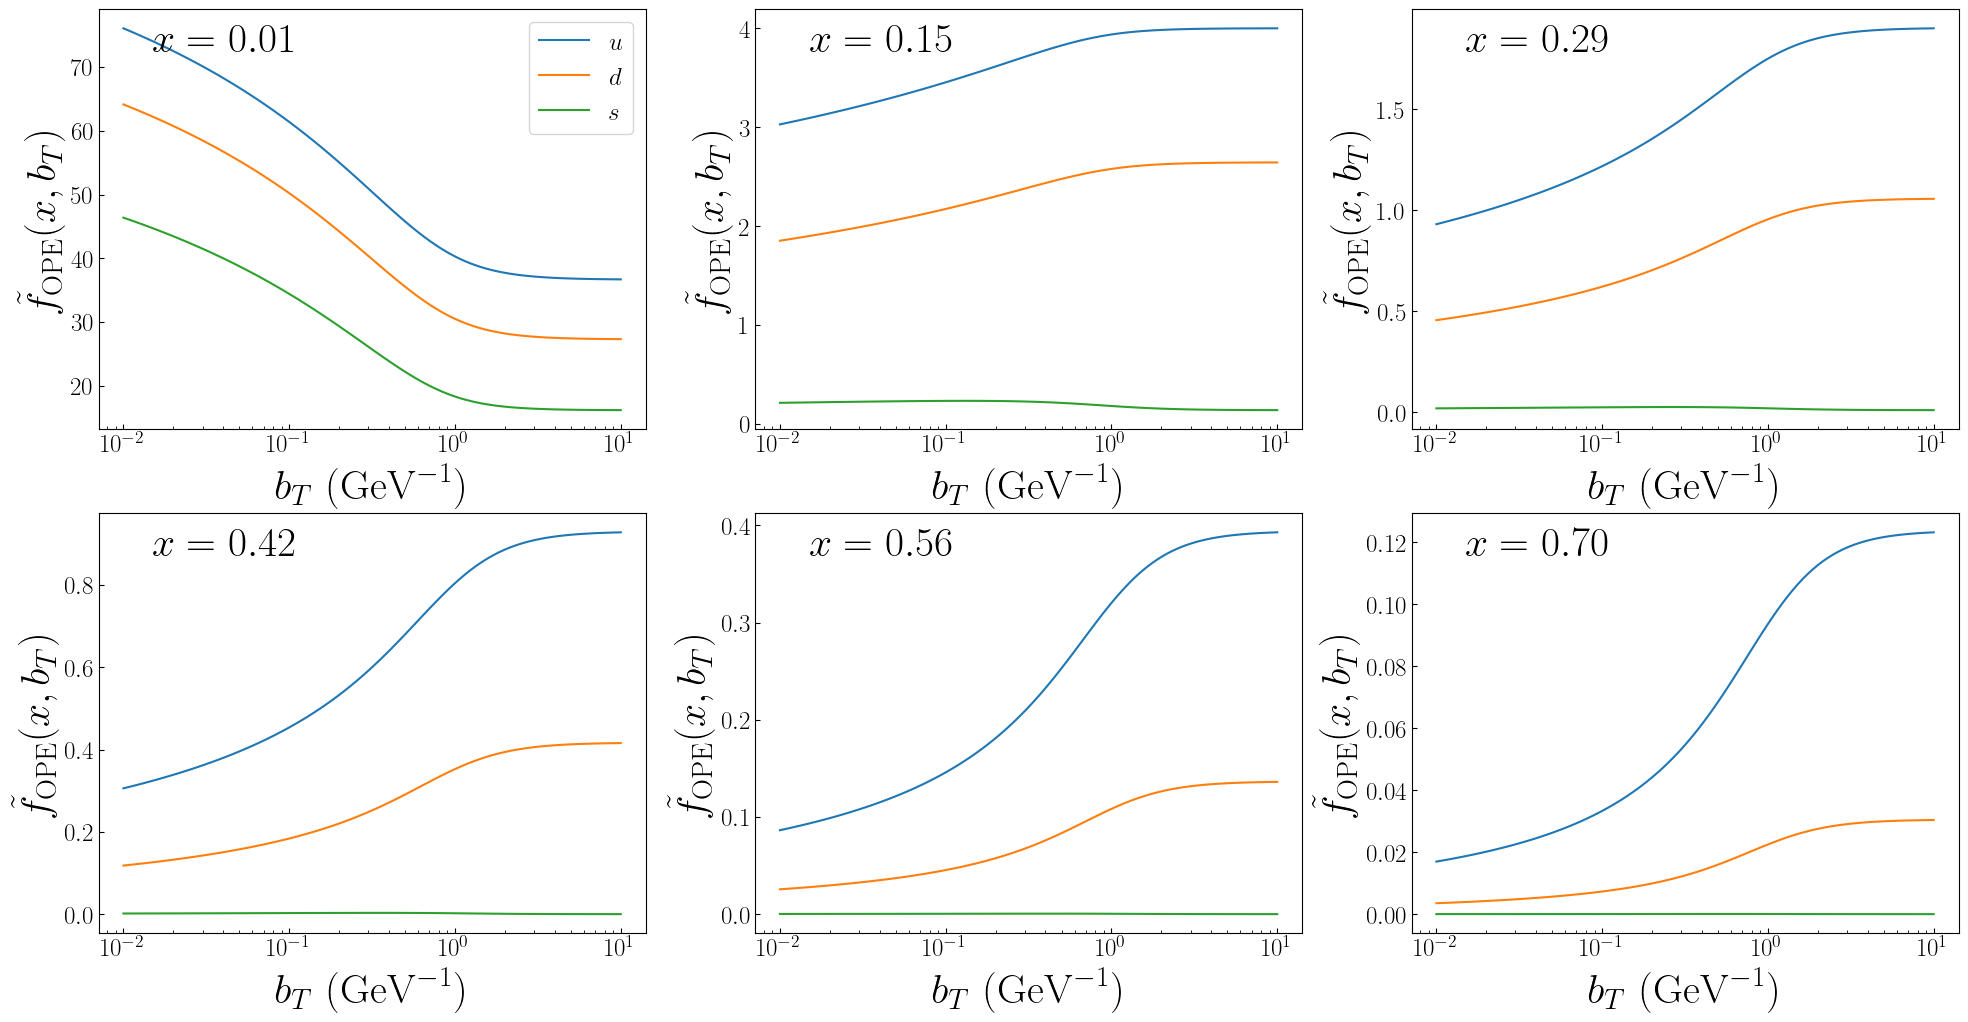

In [27]:
Xs = np.linspace(0.01,0.7,6)
bTs = 10**np.linspace(-2,1,100)

ope = PDF_OPE(pdf)

nrows,ncols=2,3
py.figure(figsize=(8*ncols,6*nrows))
cnt=0

flav_lab = [r'$g$',r'$u$',r'$d$',r'$s$',r'$c$',r'$b$',r'$\bar{b}$',r'$\bar{c}$',r'$\bar{s}$',r'$\bar{d}$',r'$\bar{u}$']
for x in Xs:
    cnt+=1
    ax=py.subplot(nrows,ncols,cnt)

    opes = np.zeros((11,len(bTs)))
    for i in range(len(bTs)):
        opetmd = ope.get_OPE_TMDPDF(x,bTs[i])
        for j in range(len(opes)):
            opes[j][i] = opetmd[j]

    for i in range(len(opes)):
        if i in [0,4,5,6,7,8,9,10]: continue
        ax.plot(bTs, opes[i],label=flav_lab[i])

    ax.semilogx()
    ax.set_xlabel(r'$b_T~({\rm GeV}^{-1})$',size=30)
    ax.set_ylabel(r'$\tilde{f}_{\rm OPE}(x,b_T)$',size=30)
    ax.text(0.1,0.9,r'$x=%.2f$'%x,transform=ax.transAxes,size=30)
    if cnt==1: ax.legend(fontsize=18)
    ax.tick_params(direction='in',labelsize=18,which='both',axis='both')

In [28]:
class PDF_OPE_MAP:
    
    def __init__(self,pdf):

        self.iorder = cfg.tmd_order #--LO: 0, NLO: 1
        
        self.pdf = pdf
        self.mellin = pdf.mellin
        
        self.tmdmodel=tmdmodel
        self.alphaS=alphaS
        
        self.CF=params.CF
        self.CA=params.CA
        self.TR=params.TR
        self.TF=params.TF
        
        #--set_charges
        quarkcharges = np.zeros(11)
        quarkcharges[0] = 0 # gluon
        quarkcharges[1] = 2/3 # u
        quarkcharges[2] =-1/3 # d
        quarkcharges[3] =-1/3 # s
        quarkcharges[4] = 2/3 # c
        quarkcharges[5] =-1/3 # b

        quarkcharges[-1] =-2/3 # baru
        quarkcharges[-2] = 1/3 # bard
        quarkcharges[-3] = 1/3 # bars
        quarkcharges[-4] =-2/3 # barc
        quarkcharges[-5] = 1/3 # barb
        self.quarkcharges=quarkcharges
        #============================================================
        #--Storages
        #============================================================

        self.storage_ope={}
        self.fmap={1:'u',2:'d',3:'s',4:'c',5:'b',-5:'bb',-4:'cb',-3:'sb',-2:'db',-1:'ub',0:'g'}
        
        self.setup()

    def reset_storage_ope(self):
        self.storage_ope={}

    #--this function is in special.get_psi(i,N)
    #def get_psi(self,i,N):
    #    return fp.psi(i,complex(N.real,N.imag))

    def setup(self):
        #============================================================
        #--Setting up OPE
        #============================================================
        N=self.mellin.N
        self.N=N
        
        psi0N = special.get_psi(0,N)
        
        self.NLOq1= -1/N - 1/(N+1) - 2*special.euler - 2*psi0N # M transform of Pqq=(2/(1-x)_{+} -1-x)
        self.NLOq2=  1/N - 1/(N+1) # M transform of (1-x)

        self.NLOg1= 1/N - 2/(N+1) + 2/(N+2)  # M transform of Pgq=1-2x(1-x)
        self.NLOg2= 1/(N+1)-1/(N+2)  # M tranform of x(1-x) 

        
    def get_OPE_TMDPDF(self,x,bT,Q):
        """
        Returns an 11-dimensional array of flavors for the OPE for a given x and bT
        x: float
        bT: float
        """
        
        #mub   = self.tmdmodel.get_mub(bT) # returns mub*
        mub = self.tmdmodel.get_mub_MAP(bT,Q)
        zeta = mub**2
        bstar = self.tmdmodel.get_bstar_MAP(bT,Q) # returns b*
        
        key=(x,bT,zeta)

        if key in self.storage_ope:
            if float(mub**2) not in self.pdf.storage:
                self.reset_storage_ope()
        
        if key not in self.storage_ope:
            
            N=self.mellin.N           

            aS=self.alphaS.get_a(mub**2) #- alphaS/(4 pi)
            
            Log=self.tmdmodel.get_Log(bstar,mub)

            self.pdf.evolve(mub**2)
            
            moments=self.pdf.storage[mub**2]

            Cq=np.ones(N.size,dtype=np.complex128)
            Cg=np.zeros(N.size,dtype=np.complex128)

            if self.iorder>=1:
                Cq+=aS*self.CF*(-4*Log**2-4*Log*np.log(zeta/mub**2)-4*Log*self.NLOq1+2*self.NLOq2-np.pi**2/6) 
                Cg+=aS*self.TF*(-4*Log*self.NLOg1+4*self.NLOg2) 

            mellin_convolutions=np.zeros((11,N.size),dtype=np.complex128)
            for i in [1,2,3,4,5]:
                mellin_convolutions[+i]=Cq*moments[self.fmap[+i]] + Cg*moments['g']
                mellin_convolutions[-i]=Cq*moments[self.fmap[-i]] + Cg*moments['g']

            xspace_convolutions=np.zeros(11)
            for i in [1,2,3,4,5]:
                xspace_convolutions[+i]=self.mellin.invert(x,mellin_convolutions[+i])
                xspace_convolutions[-i]=self.mellin.invert(x,mellin_convolutions[-i])
            self.storage_ope[key]=xspace_convolutions

        return self.storage_ope[key]


In [29]:
class FF_OPE_MAP:
    
    def __init__(self,ff):

        self.iorder = cfg.tmd_order #--LO: 0, NLO: 1
        
        self.ff = ff
        self.mellin = pdf.mellin
        
        self.tmdmodel=tmdmodel
        self.alphaS=alphaS
        
        self.CF=params.CF
        self.CA=params.CA
        self.TR=params.TR
        self.TF=params.TF
        
        #--set_charges
        quarkcharges = np.zeros(11)
        quarkcharges[0] = 0 # gluon
        quarkcharges[1] = 2/3 # u
        quarkcharges[2] =-1/3 # d
        quarkcharges[3] =-1/3 # s
        quarkcharges[4] = 2/3 # c
        quarkcharges[5] =-1/3 # b

        quarkcharges[-1] =-2/3 # baru
        quarkcharges[-2] = 1/3 # bard
        quarkcharges[-3] = 1/3 # bars
        quarkcharges[-4] =-2/3 # barc
        quarkcharges[-5] = 1/3 # barb
        self.quarkcharges=quarkcharges
        #============================================================
        #--Storages
        #============================================================

        self.storage_ope={}
        self.fmap={1:'u',2:'d',3:'s',4:'c',5:'b',-5:'bb',-4:'cb',-3:'sb',-2:'db',-1:'ub',0:'g'}
        
        self.setup()

    def reset_storage_ope(self):
        self.storage_ope={}

    #--this function is in special.get_psi(i,N)
    #def get_psi(self,i,N):
    #    return fp.psi(i,complex(N.real,N.imag))

    def setup(self):
        #============================================================
        #--Setting up OPE
        #============================================================
        N=self.mellin.N
        self.N=N
        
        psi0N = special.get_psi(0,N)
        psi1N = special.get_psi(1,N)

        """
        Please check my FF terms with Nanga Parbat!
        The pieces not proportional to Log are verified from Eq. 2.81 in JHEP06(2020)137 (SV19).
        """

        """
        quark pieces: Mellin transform of:
        alphaS * CF / 2 / pi * ( -2 * (Log - log(z)) * (2 / (1-z)_+  + 1 / z**2 + 1 / z) + 1 / z**2 - 1 / z
                                + delta(1-z) * ( -2 * Log**2 - 2 * Log * log(zeta/mu**2) - pi**2/6))
        """
        self.NLOq1= -2 * psi0N - 2 * special.euler + 1 / (N + 2) + 1 / (N + 1)
        self.NLOq2= -2 * psi1N - 1 / (N - 2)**2 - 1 / (N - 1)**2 + 1 / 2 / (N + 2) - 1 / 2 / (N + 1)

        """
        gluon pieces: Mellin transform of:
        alphaS * CF / 2 / pi / z**3 * ( -2 * (1 + (1-z)**2) * (Log - log(z)) + z**2) 
        """
        self.NLOg1= 2 / (N - 3) + 1 / (N - 1) - 2 / (N - 2) 
        self.NLOg2= -2 / (N - 3)**2 - 2 / (N - 1)**2 + 2 / (N - 2) + 1 / 2 / (N - 1)
        
    def get_OPE_TMDFF(self,z,bT,Q):
        """
        Returns an 11-dimensional array of flavors for the OPE for a given x and bT
        z: float
        bT: float
        """
        
        mub   = self.tmdmodel.get_mub_MAP(bT,Q) # returns mub*
        zeta = mub**2
        bstar = self.tmdmodel.get_bstar_MAP(bT,Q) # returns b*
        
        key=(z,bT,zeta)

        if key in self.storage_ope:
            if float(mub**2) not in self.ff.storage:
                self.reset_storage_ope()
        
        if key not in self.storage_ope:
            
            N=self.mellin.N           

            aS=self.alphaS.get_a(mub**2) #- alphaS/(4 pi)
            
            Log=self.tmdmodel.get_Log(bstar,mub)

            self.ff.evolve(mub**2)
            
            moments=self.ff.storage[mub**2]

            Cq=np.ones(N.size,dtype=np.complex128)
            Cg=np.zeros(N.size,dtype=np.complex128)

            if self.iorder>=1:
                Cq+=aS*self.CF*(-4*Log**2-4*Log*np.log(zeta/mub**2)-4*Log*self.NLOq1+4*self.NLOq2-np.pi**2/6) 
                Cg+=aS*self.CF*(-4*Log*self.NLOg1+4*self.NLOg2) 

            mellin_convolutions=np.zeros((11,N.size),dtype=np.complex128)
            for i in [1,2,3,4,5]:
                mellin_convolutions[+i]=Cq*moments[self.fmap[+i]] + Cg*moments['g']
                mellin_convolutions[-i]=Cq*moments[self.fmap[-i]] + Cg*moments['g']

            zspace_convolutions=np.zeros(11)
            for i in [1,2,3,4,5]:
                zspace_convolutions[+i]=self.mellin.invert(z,mellin_convolutions[+i])
                zspace_convolutions[-i]=self.mellin.invert(z,mellin_convolutions[-i])
            self.storage_ope[key]=zspace_convolutions

        return self.storage_ope[key]


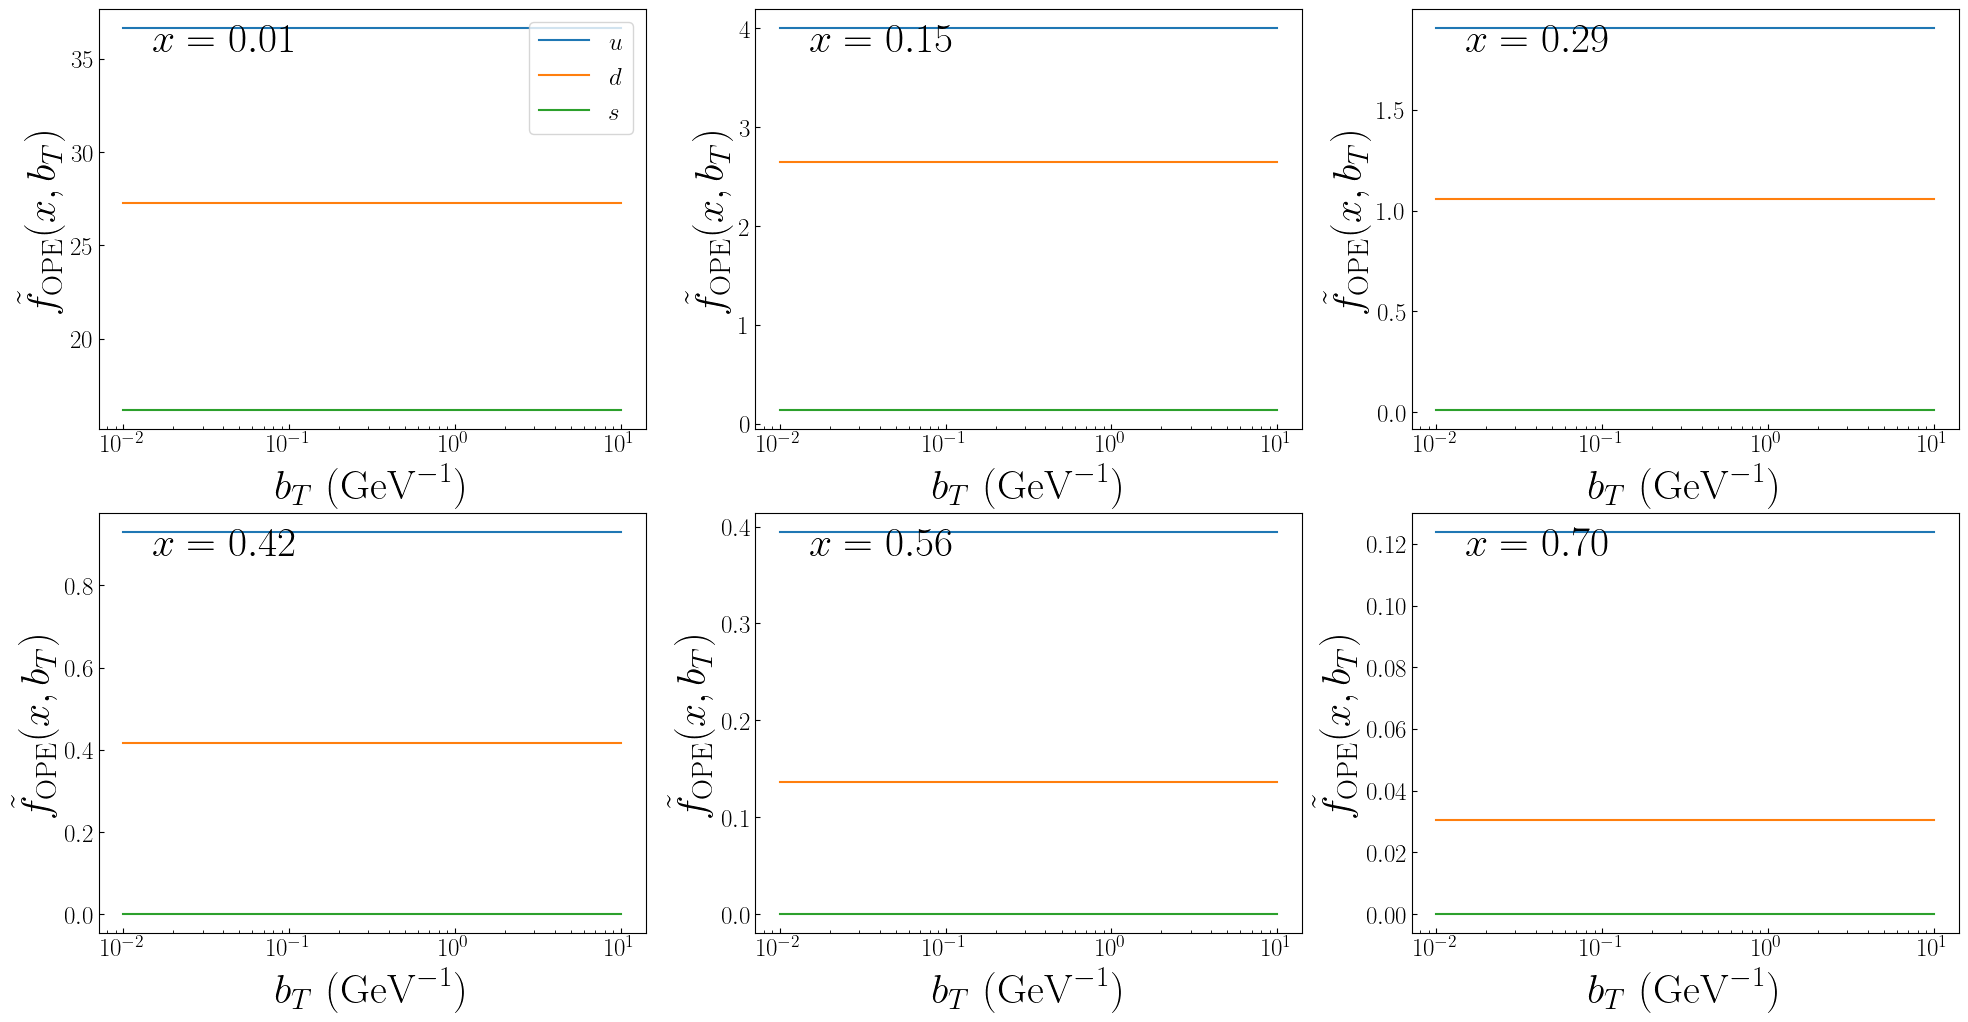

In [30]:
Xs = np.linspace(0.01,0.7,6)
bTs = 10**np.linspace(-2,1,100)
Q = tmdmodel.Q0

ope = PDF_OPE_MAP(pdf)

nrows,ncols=2,3
py.figure(figsize=(8*ncols,6*nrows))
cnt=0

flav_lab = [r'$g$',r'$u$',r'$d$',r'$s$',r'$c$',r'$b$',r'$\bar{b}$',r'$\bar{c}$',r'$\bar{s}$',r'$\bar{d}$',r'$\bar{u}$']
for x in Xs:
    cnt+=1
    ax=py.subplot(nrows,ncols,cnt)

    opes = np.zeros((11,len(bTs)))
    for i in range(len(bTs)):
        opetmd = ope.get_OPE_TMDPDF(x,bTs[i],Q)
        for j in range(len(opes)):
            opes[j][i] = opetmd[j]

    for i in range(len(opes)):
        if i in [0,4,5,6,7,8,9,10]: continue
        ax.plot(bTs, opes[i],label=flav_lab[i])

    ax.semilogx()
    ax.set_xlabel(r'$b_T~({\rm GeV}^{-1})$',size=30)
    ax.set_ylabel(r'$\tilde{f}_{\rm OPE}(x,b_T)$',size=30)
    ax.text(0.1,0.9,r'$x=%.2f$'%x,transform=ax.transAxes,size=30)
    if cnt==1: ax.legend(fontsize=18)
    ax.tick_params(direction='in',labelsize=18,which='both',axis='both')

In [31]:
class PERTURBATIVE_EVOLUTION:
    
    def __init__(self,alphaS,tmdmodel,iorder=cfg.tmd_resummation_order):

        self.iorder = iorder

        self.CF=params.CF
        self.CA=params.CA
        self.TR=params.TR
        self.TF=params.TF
        self.zeta2 = zeta(2)
        self.zeta3 = zeta(3)
        self.zeta4 = zeta(4)
        self.zeta5 = zeta(5)

        self.alphaS = alphaS
        self.tmdmodel=tmdmodel

        self.storage_Sudakov={}

    def reset_storage_Sudakov(self):
        self.storage_Sudakov={}


    #============================================================
    #--Setting up Gamma_cusp
    #============================================================
    """
    \$\Gamma\$-cusp

     notice the following correspondence from https://arxiv.org/pdf/1803.11089.pdf 

     Rogers17_PhysRevD.96.054011.pdf uses gamma_K = 2 gamma_Cusp
     - Cusp anomalous dimension expanded in alphaS, Eq. (59) of PhysRevD.96.054011
     """

    def get_Gamma0(self,mu):
        #--aS**1
        Nf=self.alphaS.get_Nf(mu**2)
        return 4. * self.CF

    def get_Gamma1(self,mu):
        #--aS**2
        Nf=self.alphaS.get_Nf(mu**2)
        return 4 * self.CF * (self.CA * (67/9 - np.pi**2/3)\
                   - 20/9 * self.TR * Nf)

    def get_Gamma2(self,mu):
        #--aS**3
        Nf=self.alphaS.get_Nf(mu**2)
        return 4 * self.CF *(self.CA**2 * (245/6 - 134/27*np.pi**2 + 11/45*np.pi**4 + 22/3*self.zeta3) \
                    + self.CA * self.TR * Nf * (-418/27 + 40/27*np.pi**2 - 56/3*self.zeta3)\
                    + self.CF * self.TR * Nf * (-55/3 + 16 * self.zeta3) - 16/27 * self.TR**2 * Nf**2 )

    def get_Gamma3(self,mu):
        #--aS**4
        Nf=self.alphaS.get_Nf(mu**2)
        dFA=15/16 #--d_F^{abcd}d_A^{abcd}/(N^2-1)
        dFF=5/96 #--d_F^{abcd}d_F^{abcd}/(N^2-1)

        return  self.CF*( \
                dFA*(7040/3*self.zeta5 +256/3*self.zeta3-768*(self.zeta3**2) -256*self.zeta2 -15872/35*(self.zeta2**3))\
                +dFF*Nf*(-2560/3*self.zeta5 -512/3*self.zeta3 +512*self.zeta2)\
                +(Nf**3)*(-32/81 +64/27*self.zeta3)\
                +self.CF*(Nf**2)*(2392/81 -640/9*self.zeta3 +64/5*(self.zeta2**2))\
                +(self.CF**2)*Nf*(572/9 -320*self.zeta5 +592/3*self.zeta3)\
                +self.CA*(Nf**2)*(923/81 +2240/27*self.zeta3 -608/81*self.zeta2 -224/15*(self.zeta2**2))\
                +self.CF*self.CA*Nf*(-34066/81 +160*self.zeta5 +3712/9*self.zeta3 +440/3*self.zeta2 -128*self.zeta2*self.zeta3 -352/5*(self.zeta2**2))\
                +(self.CA**2)*Nf*(-24137/81 +2096/9*self.zeta5 -23104/27*self.zeta3 +20320/81*self.zeta2 \
                +448/3*self.zeta2*self.zeta3 -352/15*(self.zeta2**2))\
                +(self.CA**3)*(84278/81 - 3608/9*self.zeta5 +20944/27*self.zeta3 -16*(self.zeta3**2) \
                -88400/81*self.zeta2 -352/3*self.zeta2*self.zeta3 +3608/5*(self.zeta2**2)-20032/105*(self.zeta2**3)))     


    #============================================================
    #--Setting up gamma_J
    #============================================================
    """
    Here we calculate the \$\gamma_{J}\$ Eq. (58) of PhysRevD.96.054011
    """
    def get_gammaJ1(self,mu):
        #--aS**1
        Nf=self.alphaS.get_Nf(mu**2)
        return 6. * self.CF

    def get_gammaJ2(self,mu):
        #--aS**2
        Nf=self.alphaS.get_Nf(mu**2)
        return  self.CF**2 * (3. - 4. * np.pi**2 + 48. * self.zeta3)\
                        + self.CF * self.CA * (961./27. + 11. * np.pi**2/3. - 52. * self.zeta3)\
                        + self.CF * Nf * (-130./27. - 2. * np.pi**2/3.) 

    def get_gammaJ3(self,mu):
        #--aS**3
        Nf=self.alphaS.get_Nf(mu**2)
        return  self.CF**2 * Nf * (-2953./27. + 26. * np.pi**2/9 + 28. * np.pi**4/27 - 512. * self.zeta3/9.)\
                        + self.CF * Nf**2 * (-4834./729. + 20. * np.pi**2/27. + 16. * self.zeta3/27. )\
                        + self.CF**3 * (29. + 6. * np.pi**2 + 16. * np.pi**4/5. + 136. * self.zeta3 - 32. * np.pi**2 * self.zeta3/3. - 480. * self.zeta5)\
                        + self.CA**2 * self.CF * (139345./1458. + 7163. * np.pi**2/243. + 83. * np.pi**4/45. - 7052. * self.zeta3/9. + 88. * np.pi**2 * self.zeta3/9. + 272. * self.zeta5 )\
                        + self.CA * self.CF * Nf * (17318./729. - 2594. * np.pi**2/243. - 22. * np.pi**4/45. + 1928. * self.zeta3/27.)\
                        + self.CA * self.CF**2 * (151./2. - 410. * np.pi**2/9. - 494. * np.pi**4/135. + 1688. * self.zeta3/3. + 16. * np.pi**2 * self.zeta3/3. + 240. * self.zeta5)


    #============================================================
    #--Setting up perturbative evolution
    #============================================================
    """
    Perturbative part of the evolution  (perturbative Sudakov and Collins-Soper kernel)

    for gamma3 we use Eq. (D9) on p. 36 of 1604.07869, using that Ktilde =  -2D
    """

    def get_Ktilde(self,bT,mu):
        """
        Collins-Soper kernel at small bT can be expanded in alphaS, Eq. (69) of PhysRevD.96.054011
        """

        aS=self.alphaS.get_a(mu**2) #- alphaS/(4 pi)
        log=self.tmdmodel.get_Log(bT,mu) #- Typical logarithm
        Nf=self.alphaS.get_Nf(mu**2)

        ##### for N3LL term - see 1604.07869 #####
        Gamma1 = 1
        Gamma2 = (67/9-np.pi**2/3)*self.CA - (20/9)*self.TR*Nf
        Gamma3 = self.CA**2*(245/6 - 134*np.pi**2/27 + 11*np.pi**4/45 + 22*self.zeta3/3) \
                        + self.CA*self.TR*Nf*(-418/27 + 40*np.pi**2/27 - 56*self.zeta3/3) \
                        + self.CF*self.TR*Nf*(-55/3 + 16*self.zeta3) - (16/27)*self.TR**2*Nf**2
        beta1 = (11/3)*self.CA - (4/3)*self.TR*Nf # 
        beta2 = 34*self.CA**2/3 - 20*self.CA*self.TR*Nf/3 - 4*self.CF*self.TR*Nf # 

        d20 = self.CA*(404/27 - 14*self.zeta3) - 112*self.TR*Nf/27
        d33 = (2/3)*Gamma1*beta1**2
        d32 = 2*Gamma2*beta1 + Gamma1*beta2
        d31 = 2*beta1*d20 + 2*Gamma3
        d30 = (-self.CA**2/2)*(-176*self.zeta3*self.zeta2/3 + 6392*self.zeta2/81 + 12328*self.zeta3/27 + 154*self.zeta4/3 - 192*self.zeta5 - 297029/729) \
                    - self.CA*self.TR*Nf*(-824*self.zeta2/81 - 904*self.zeta3/27 + 20*self.zeta4/3 + 62626/729) \
                    - 2*self.TR**2*Nf**2*(-32*self.zeta3/9 - 1856/729) \
                    - self.CF*self.TR*Nf*(-304*self.zeta3/9 - 16*self.zeta4 + 1711/27)
        ######################################

        Ktilde = 0

        if self.iorder>0: 

            Ktilde += -8 * self.CF * aS * log

        if self.iorder>1:

            Ktilde += 8 * self.CF * aS**2 * (  \
                        +  (2/3 * Nf - 11/3 * self.CA) * log**2 \
                        +  (-67/9 * self.CA + np.pi**2/3 * self.CA + 10/9 * Nf) * log \
                        +  (7/2 * self.zeta3 - 101/27) * self.CA + 14/27 * Nf )

        if self.iorder>2: # Eq. (D9) on p. 36 of 1604.07869, using that Ktilde =  -2D

            Ktilde += -2*self.CF*aS**3 * (d30 +  2*log*d31 + 4*log**2*d32 + 8*log**3*d33) #see 1604.07869

        return Ktilde


    def get_gammaF(self,mu):
        """
        Anomalous dimension of TMD operator expanded in alphaS, Eq. (58) of PhysRevD.96.054011
        """

        aS=self.alphaS.get_a(mu**2) #- alphaS/(4 pi)

        gammaF = 0

        if self.iorder>0:
            GAMMA1 = self.get_gammaJ1(mu)
            gammaF += GAMMA1 * aS

        if self.iorder>1:
            GAMMA2 = self.get_gammaJ2(mu)           
            gammaF += aS**2 * GAMMA2

        if self.iorder>2:
            GAMMA3 = self.get_gammaJ3(mu)
            gammaF += aS**3 * GAMMA3

        return gammaF

    def get_gammaK(self,mu):
        """
        Cusp anomalous dimension expanded in alphaS, Eq. (59) of PhysRevD.96.054011
        """

        aS=self.alphaS.get_a(mu**2) #- alphaS/(4 pi)

        gamma0 = self.get_Gamma0(mu)        
        gammaK = 2 * gamma0 * aS

        if self.iorder>0: 
            gamma1 = self.get_Gamma1(mu)
            gammaK += aS**2 * 2 * gamma1

        if self.iorder>1:
            gamma2 = self.get_Gamma2(mu)
            gammaK += aS**3 * 2 * gamma2

        if self.iorder>2:
            gamma3 = self.get_Gamma3(mu)
            gammaK += aS**4 * 2 * gamma3

        return gammaK

    def get_integrand_gammas(self,mup,zeta):
        return 1/mup*(self.get_gammaF(mup)-np.log(np.sqrt(zeta)/mup)*self.get_gammaK(mup))
        #return 1/mup*(-np.log(np.sqrt(zeta)/mup)*self.get_gammaK(mup))


    def get_Sudakov_perturbative(self,muQ,zeta,bT,fromQ0=False):
        """
        perturbative part of the evolution in the solution 
        maximizing perturbative precision, 
        Eq. (26) of PhysRevD.96.054011 
        Returns perturbative Sudakov using b* and mub* 
        """
        mub   = self.tmdmodel.get_mub(bT) # returns mub*
        bstar = self.tmdmodel.get_bstar(bT) # returns b*

        key = (muQ,zeta,bstar,self.iorder,fromQ0)
        if key not in self.storage_Sudakov:
            if fromQ0:
                integral_gammas=quad(lambda mup: self.get_integrand_gammas(mup,zeta),fromQ0,muQ)[0]            
                self.storage_Sudakov[key]=np.log(np.sqrt(zeta)/fromQ0)*(self.get_Ktilde(bstar,mub) + quad(lambda mup: 1/mup * self.get_gammaK(mup),fromQ0,mub)[0]) + integral_gammas         
                # self.storage_Sudakov[key]=integral_gammas
                # self.storage_Sudakov[key]=np.log(np.sqrt(zeta)/fromQ0)*(quad(lambda mup: 1/mup * self.get_gammaK(mup),fromQ0,mub)[0])# + integral_gammas
            else:
                integral_gammas=quad(lambda mup: self.get_integrand_gammas(mup,zeta),mub,muQ)[0]            
                self.storage_Sudakov[key]=np.log(np.sqrt(zeta)/mub)*self.get_Ktilde(bstar,mub) + integral_gammas
        return self.storage_Sudakov[key] 

    def get_exp_Sudakov_perturbative(self,Q,bT,fromQ0=False):
        """
        Exponential of perturbative part of the evolution 
        in the solution maximizing perturbative precision, 
        Eq. (26) of PhysRevD.96.054011


        For the purposes of this code, I am assuming that zeta=Q**2 and that muQ = Q.
        This does not necessarily have to happen!
        """
        muQ = Q
        zeta = Q**2
        return np.exp(self.get_Sudakov_perturbative(muQ,zeta,bT,fromQ0=fromQ0)) 


In [32]:
pertevo = PERTURBATIVE_EVOLUTION(alphaS,tmdmodel,iorder=3)

In [33]:

bTs = 10**np.linspace(-2,2,100)
Q = np.linspace(3,100,50)

sud = np.zeros((len(bTs),len(Q)))
t0=time.time()
for i in range(len(bTs)):
    for j in range(len(Q)):
        # sud.append(pertevo.get_exp_Sudakov_perturbative(Q,bTs[i]))
        sud[i][j] = pertevo.get_exp_Sudakov_perturbative(Q[j],bTs[i],fromQ0=params.mc2**0.5)
#sud=np.array(sud)
t1=time.time()
t_numerical = t1-t0
print(f"Time taken numerical: {t_numerical} seconds")


Time taken numerical: 17.73861289024353 seconds


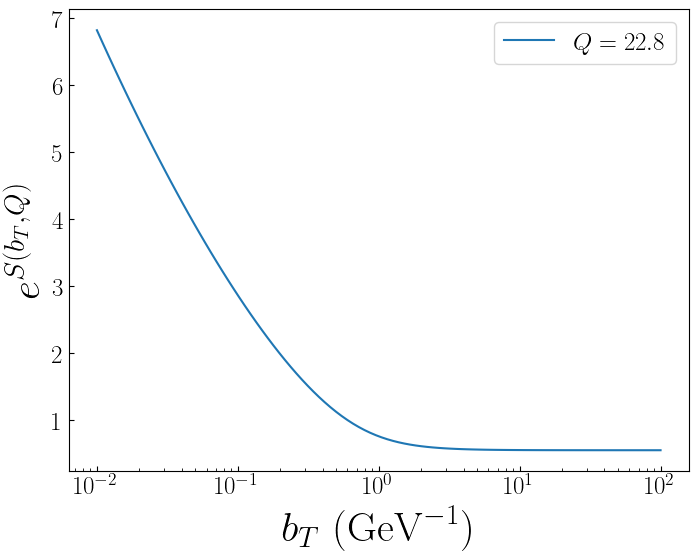

In [34]:
nrows,ncols = 1,1
py.figure(figsize=(8*ncols,6*nrows))
ax=py.subplot(nrows,ncols,1)

idx = 10
ax.plot(bTs,sud.T[idx],label=r'$Q=%.1f$'%Q[idx])
ax.semilogx()
ax.set_xlabel(r'$b_T~({\rm GeV}^{-1})$',size=30)
ax.set_ylabel(r'$e^{S(b_T,Q)}$',size=30)
ax.tick_params(direction='in',labelsize=18,which='both',axis='both')
ax.legend(fontsize=18)

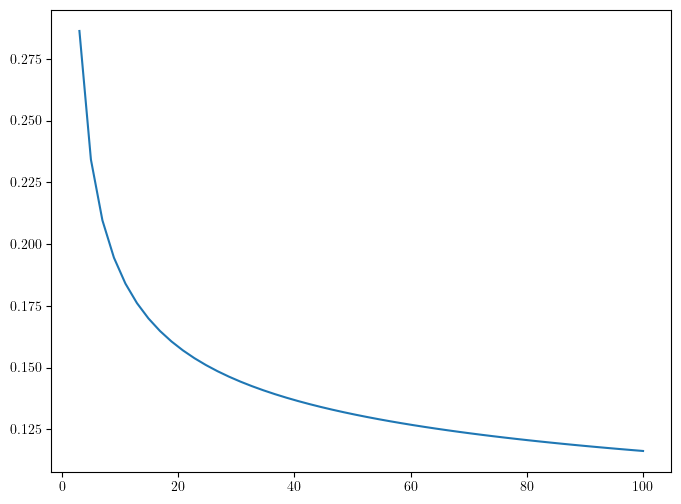

In [35]:
nrows,ncols=1,1
py.figure(figsize=(8*ncols,6*nrows))
ax=py.subplot(nrows,ncols,1)

alphaSs = np.array([alphaS.get_alphaS(_**2) for _ in Q])
ax.plot(Q,alphaSs)

## Setting up the analytic calculation of the evolution
### This will eventually go into a standalone file

In [36]:
class MODEL_TORCH:
    
    def __init__(self):
        #--params
        euler=special.euler

        self.Q0 = torch.sqrt(torch.tensor(cfg.Q20))
        self.C1=2*torch.exp(torch.tensor(-euler))
        self.C2=1
        
        self.bmax = self.C1/self.Q0 #--so that mub > mu_0
    
    #============================================================
    #--Defining functions associated with bstar
    #============================================================
    #--typical logarithm in perturbative expansions
    def get_Log(self,bT,mu):  
        """
        Typical log in the expansion
        """
        return torch.log(mu*bT/self.C1)

    #--Setting up b_*
    def get_bstar(self,bT):
        """
        Returns b*
        """
        return bT/torch.sqrt(1+bT**2/self.bmax**2)

    def get_bmin(self,Q):
        """
        Returns bmin
        """
        return self.C1/Q

    #--Setting up b_* a la MAP
    def get_bstar_MAP(self,bT,Q):
        """
        Returns b*
        """
        bmax = self.bmax
        bmin = self.get_bmin(Q)
        return bmax * ((1 - torch.exp(-bT**4 / bmax**4)) / (1 - torch.exp(-bT**4 / bmin**4)))**(0.25)

    def get_mub(self,bT): 
        """
        Returns mub* 
        """
        return self.C1/self.get_bstar(bT)

    def get_mub_MAP(self,bT,Q): 
        """
        Returns mub* a la MAP
        """
        return self.C1/self.get_bstar_MAP(bT,Q)



In [37]:
CF=params.CF
CA=params.CA
TR=params.TR
TF=params.TF
zeta2 = zeta(2)
zeta3 = zeta(3)
zeta4 = zeta(4)
zeta5 = zeta(5)

from scipy.special import spence


In [38]:
z = torch.tensor([0.5+0.5j,0.5-0.5j,0.5+0.5j,0.5-0.5j])
spence(1-z)

/var/folders/g4/lx3qy8yd27q_qjssg5ksf0nh0000gr/T/ipykernel_67554/4029848101.py:2: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  spence(1-z)


tensor([0.4540+0.6438j, 0.4540-0.6438j, 0.4540+0.6438j, 0.4540-0.6438j])

In [39]:
tmdmodel_torch = MODEL_TORCH()

In [40]:
def get_betas():
    beta0 = lambda Nf: alphaS.beta[Nf,0]
    beta1 = lambda Nf: alphaS.beta[Nf,1]
    beta2 = lambda Nf: alphaS.beta[Nf,2]
    beta3 = lambda Nf: alphaS.beta[Nf,3]

    beta = torch.zeros((7,4))
    for Nf in range(3,7):
        beta[Nf] = torch.tensor([beta0(Nf),beta1(Nf),beta2(Nf),beta3(Nf)])
    return beta

betas=get_betas()

In [41]:
#=================================================================================
#--Setting up the roots of the beta function to evaluate the Sudakov analytically
#=================================================================================
"""
These are the setup of the deltas as in https://inspirehep.net/literature/1950250, Eqs. 3.11, 3.12, A.4, A.5, A.9, A.10.
This is how artemide performs the calculation.
Namely, we have the shape of the roots according to (Order of resummation (iorder), Order of summation trucation (n_sum), Nf)

\eta_\Gamma = -1 / 2 * \sum_{i=0}^{n_sum} r_{Gamma,i} \log((\alpha_S(mu) - 4 * np.pi * delta_{i,iorder}) / (\alpha_S(mu_0) - 4 * np.pi * delta_{i,iorder}))

K_\gamma = -1 / 2 * \sum_{i=0}^{n_sum} r_{gamma,i} \log((\alpha_S(mu) - 4 * np.pi * delta_{i,iorder}) / (\alpha_S(mu_0) - 4 * np.pi * delta_{i,iorder}))

K_\Gamma  is more complicated and is given by Eq. 3.17 of https://inspirehep.net/literature/1950250
"""

def setup_beta_roots():

    """
    These terms agree with artemide up to NNLL with the exception of Nf=6.
    The shape is (4,4,7). First index is the order of resummation, second is the order of truncation, third is the number of flavors.
    """
    delta=torch.zeros((4,4,7),dtype=torch.complex128)
    #--LL
    #--delta[0] = 0 for LL
    #--delta_0 = 0 for all orders

    beta = get_betas()

    #--NLL
    for Nf in range(3,7):
        delta[1][1][Nf] = -beta[Nf,0] / beta[Nf,1]
    
    #--N2LL
    for i in [1,2]:
        if i==1: sign = 1
        elif i==2: sign = -1
        for Nf in range(3,7):
            real = -beta[Nf,1] / 2 / beta[Nf,2]
        
            radicand = 4*beta[Nf,0] * beta[Nf,2] - beta[Nf,1]**2
            
            rad_sign = torch.sign(radicand)
            if rad_sign == -1:
                delta[2][i][Nf] = real - sign * torch.sqrt(torch.abs(radicand)) / 2 / beta[Nf,2]
            else:
                delta[2][i][Nf] = complex(real,sign * torch.sqrt(radicand) / 2 / beta[Nf,2])

    #--N3LL
    for Nf in range(3,7):
        #--In our case up to Nf=6, we do not have any negative values in square roots.
        Delta0 = beta[Nf,2]**2 - 3 * beta[Nf,1] * beta[Nf,3]
        Delta1 = beta[Nf,2]**3 - 9/2 * beta[Nf,3] * (beta[Nf,1] * beta[Nf,2] - 3 * beta[Nf,0] * beta[Nf,3])
        C = (Delta1 + torch.sqrt(Delta1**2 - Delta0**3))**(1/3)
        xi = complex(-1/2,torch.sqrt(torch.tensor(3))/2)

        for i in [1,2,3]:
            delta[3][i][Nf] = -1 / 3 / beta[Nf,3] * (beta[Nf,2] + xi**(i) * C + Delta0 / xi**(i) / C)
    
    return delta
delta = setup_beta_roots()

In [42]:
def setup_beta_prime():
    beta = get_betas()

    beta_prime=torch.zeros((4,4,7),dtype=torch.complex128)

    for i in range(4):
        #--looping over orders of resummation
        for j in range(4):
            #--looping over roots of the beta (from delta)
            for Nf in range(3,7):
                #--looping over number of flavors
                delta_ij = delta[i][j][Nf]
                for k in range(i+1): #--we go from 0 to i, but in torch we have range up to i+1
                    beta_prime[i][j][Nf] += -2 * (k+2) * beta[Nf,k] * delta_ij**(k+1)
    return beta_prime
beta_prime = setup_beta_prime()
        

In [43]:
#============================================================
#--Setting up Gamma_cusp (or gamma_K in CSS)
#============================================================
"""
\$\Gamma\$-cusp

    notice the following correspondence from https://arxiv.org/pdf/1803.11089.pdf 

    Rogers17_PhysRevD.96.054011.pdf uses gamma_K = 2 gamma_Cusp
    - Cusp anomalous dimension expanded in alphaS, Eq. (59) of PhysRevD.96.054011
    https://inspirehep.net/literature/1452696 Appendix D notice that one should use \$\Gamma^{(n-1)}\$ in other parts 


the 4-loop expression is taken from [2001.11377] (appendix C)
    """

def get_Gamma0(Nf):
    """
    PCB checked consistency with artemide: 1/10/2025
    """
    #--aS**1
    #Nf=self.alphaS.get_Nf(mu**2)
    return 4. * CF

def get_Gamma1(Nf):
    """
    PCB checked consistency with artemide: 1/10/2025
    """
    #--aS**2
    #Nf=self.alphaS.get_Nf(mu**2)
    return 4 * CF * (CA * (67/9 - torch.pi**2/3)\
                - 20/9 * TR * Nf)

def get_Gamma2(Nf):
    """
    PCB checked consistency with artemide: 1/10/2025
    """
    #--aS**3
    #Nf=self.alphaS.get_Nf(mu**2)
    return 4 * CF *(CA**2 * (245/6 - 134/27*torch.pi**2 + 11/45*torch.pi**4 + 22/3*zeta3) \
                + CA * TR * Nf * (-418/27 + 40/27*torch.pi**2 - 56/3*zeta3)\
                + CF * TR * Nf * (-55/3 + 16 * zeta3) - 16/27 * TR**2 * Nf**2 )

def get_Gamma3(Nf):
    """
    PCB checked consistency with artemide: 1/10/2025
    """
    #--aS**4
    #Nf=self.alphaS.get_Nf(mu**2)
    dFA=15/16 #--d_F^{abcd}d_A^{abcd}/(N^2-1)
    dFF=5/96 #--d_F^{abcd}d_F^{abcd}/(N^2-1)

    return  CF*( \
            dFA*(7040/3*zeta5 +256/3*zeta3-768*(zeta3**2) -256*zeta2 -15872/35*(zeta2**3))\
            +dFF*Nf*(-2560/3*zeta5 -512/3*zeta3 +512*zeta2)\
            +(Nf**3)*(-32/81 +64/27*zeta3)\
            +CF*(Nf**2)*(2392/81 -640/9*zeta3 +64/5*(zeta2**2))\
            +(CF**2)*Nf*(572/9 -320*zeta5 +592/3*zeta3)\
            +CA*(Nf**2)*(923/81 +2240/27*zeta3 -608/81*zeta2 -224/15*(zeta2**2))\
            +CF*CA*Nf*(-34066/81 +160*zeta5 +3712/9*zeta3 +440/3*zeta2 -128*zeta2*zeta3 -352/5*(zeta2**2))\
            +(CA**2)*Nf*(-24137/81 +2096/9*zeta5 -23104/27*zeta3 +20320/81*zeta2 \
            +448/3*zeta2*zeta3 -352/15*(zeta2**2))\
            +(CA**3)*(84278/81 - 3608/9*zeta5 +20944/27*zeta3 -16*(zeta3**2) \
            -88400/81*zeta2 -352/3*zeta2*zeta3 +3608/5*(zeta2**2)-20032/105*(zeta2**3)))       

Gamma = torch.zeros((7,4),dtype=torch.complex128)
for Nf in range(3,7):
    Gamma[Nf] = torch.tensor([get_Gamma0(Nf),get_Gamma1(Nf),get_Gamma2(Nf),get_Gamma3(Nf)])

def get_Gammas():
    Gammas = torch.zeros((4,4,7),dtype=torch.complex128)
    for i in range(4): #--this is the order of resummation
        for j in range(4): #--this is the order of the delta
            for Nf in range(3,7): #--this is the number of flavors
                delta_ij = delta[i][j][Nf]
                for k in range(i+1): #--we go from 0 to i, but in torch we have range up to i+1
                    Gammas[i][j][Nf] += Gamma[Nf][k] * delta_ij**(k+1)
    return Gammas

Gammas = get_Gammas()

In [44]:
# a = torch.tensor(-0.0497+0.1073j, dtype=torch.complex128)
# b = torch.tensor(5.3333+0.j, dtype=torch.complex128)
# print(a**(1)*b)

In [45]:
#============================================================
#--Setting up gamma_V 
#  https://inspirehep.net/literature/1452696 Appendix D
#============================================================
"""
Here we calculate the \$\gamma_{V}\$ https://inspirehep.net/literature/1452696 Appendix D
"""
def get_gammaV1(Nf):
    """
    PCB checked consistency with artemide: 1/10/2025
    """
    #--aS**1
    # Nf=self.alphaS.get_Nf(mu**2)
    return -6. * CF

def get_gammaV2(Nf):
    """
    PCB checked consistency with artemide: 1/10/2025
    """
    #--aS**2
    #Nf=self.alphaS.get_Nf(mu**2)
    return  CF**2 * (-3 + 4*torch.pi**2 - 48*zeta3) + CF*CA*(-961/27-11*torch.pi**2/3+52*zeta3) + \
            CF*TR*Nf*(260/27+4*torch.pi**2/3.)

def get_gammaV3(Nf):
    """
    PCB checked consistency with artemide: 1/10/2025
    """
    #--aS**3
    #Nf=self.alphaS.get_Nf(mu**2)
    
    pi = torch.pi   
    return  CF**3 * (-29 - 6*pi**2 - 16/5*pi**4 - 136*zeta3 + 32*pi**2/3 * zeta3 + 480*zeta5) + \
        CF**2*CA *(-151/2 + 410/9*pi**2 + 494*pi**4/135 - 1688/3*zeta3 - 16/3*pi**2*zeta3 - 240*zeta5) + \
        CF*CA**2 *(-139345/1458-7163/243*pi**2-83/45*pi**4+7052/9*zeta3-88/9*pi**2*zeta3-272*zeta5)+\
        CF**2*TR*Nf*(5906/27-52/9*pi**2-56/27*pi**4+1024/9*zeta3) + \
        CF*CA*TR*Nf*(-34636/729+5188/243*pi**2+44/45*pi**4-3856/27*zeta3) +  \
        CF*TR**2*Nf**2*(19336/729-80/27*pi**2-64/27*zeta3)

gamma = torch.zeros((7,3),dtype=torch.complex128) #--note here that we have 3 because we do not count the gammaV0
for Nf in range(3,7):
    gamma[Nf] = torch.tensor([get_gammaV1(Nf),get_gammaV2(Nf),get_gammaV3(Nf)])

def get_gammas():
    gammas = torch.zeros((4,4,7),dtype=torch.complex128)
    for i in range(4): #--this is the order of resummation
        for j in range(4): #--this is the order of the delta
            for Nf in range(3,7): #--this is the number of flavors
                delta_ij = delta[i][j][Nf]
                for k in range(i): #--we go from 0 to i-1, so in torch we have range up to i
                    gammas[i][j][Nf] += gamma[Nf][k] * delta_ij**(k+1)
    return gammas

gammas = get_gammas()

In [46]:
# gammas#.shape
Gammas[3]
# delta[2]

tensor([[ 0.0000+0.0000e+00j,  0.0000+0.0000e+00j,  0.0000+0.0000e+00j,
          0.0000+0.0000e+00j,  0.0000+0.0000e+00j,  0.0000+0.0000e+00j,
          0.0000+0.0000e+00j],
        [ 0.0000+0.0000e+00j,  0.0000+0.0000e+00j,  0.0000+0.0000e+00j,
         -0.1905+1.1219e-01j, -0.3450-5.7666e-02j, -0.6080-5.9772e-01j,
         -0.2289-2.8749e+00j],
        [ 0.0000+0.0000e+00j,  0.0000+0.0000e+00j,  0.0000+0.0000e+00j,
         -0.1905-1.1219e-01j, -0.3450+5.7666e-02j, -0.6080+5.9772e-01j,
         -0.2289+2.8749e+00j],
        [ 0.0000+0.0000e+00j,  0.0000+0.0000e+00j,  0.0000+0.0000e+00j,
         -0.0876+2.0020e-08j, -0.2124+7.9485e-09j, -0.4140-1.5464e-08j,
         -0.7065-5.9502e-08j]], dtype=torch.complex128)

In [47]:
# Replace division by zero with 0
r_Gamma = torch.where(beta_prime != 0, -2 * Gammas / beta_prime, 0)
r_gamma = torch.where(beta_prime != 0, -2 * gammas / beta_prime, 0)

rbar = torch.where(beta_prime != 0, -2 / beta_prime, 0)

In [48]:
for i in range(4):
    for j in range(4):
        if j!=0: continue
        for Nf in range(3,7):
            r_Gamma[i][j][Nf] = get_Gamma0(Nf) / betas[Nf][0]
            if i>0: r_gamma[i][j][Nf] = get_gammaV1(Nf) / betas[Nf][0]
            if i>0: rbar[i][j][Nf] = -betas[Nf][1] / betas[Nf][0]**2

In [49]:
rbar0prime = torch.zeros(7)
for Nf in range(3,7):
    rbar0prime[Nf] = 1 / betas[Nf][0]


In [50]:
class PERTURBATIVE_EVOLUTION_ANALYTIC_EBERT(torch.nn.Module):

    """
    This is written exactly as in Ebert, 2110.11360.
    For other functions, we need to write them.
    """
    def __init__(self, order: int=1):
        super().__init__()
        self.order = order

        self.r_Gamma = r_Gamma[self.order]
        self.r_gamma = r_gamma[self.order]
        self.rbar = rbar[self.order]
        self.rbar0prime = rbar0prime #--note that this is a tensor of shape (7,)
        self.delta = delta[self.order]

        self.alphaS = alphaS

    def Li2_torch(self, z):
        """
        True dilogarithm Li₂(z) using mpmath.polylog(2, z)
        """
        if isinstance(z, torch.Tensor):
            z_np = z.detach().cpu().numpy()
            
            # Handle both scalar and array cases
            if np.isscalar(z_np):
                result = complex(mpmath.polylog(2, complex(z_np)))
            else:
                result = np.array([complex(mpmath.polylog(2, complex(zi))) 
                                for zi in z_np.flat]).reshape(z_np.shape)
            
            return torch.tensor(result, dtype=z.dtype, device=z.device)
        else:
            return torch.tensor(complex(mpmath.polylog(2, complex(z))))

    def get_eta_Gamma(self, alphaS_f: torch.Tensor, alphaS_i: torch.Tensor, Nf: int) -> torch.Tensor:
        """
        Get the integral of the cusp anomalous dimension over the range of alphaS.
        alphaS_f: shape (nQ2,)
        alphaS_i: scalar
        delta: shape (4,)
        Result: shape (nQ2,) - same as alphaS_f
        """
        r_Gamma = self.r_Gamma.T[Nf]  # Shape: (4,)
        delta = self.delta.T[Nf]      # Shape: (4,)
        
        # Add dimensions for broadcasting
        alphaS_f_expanded = alphaS_f.unsqueeze(-1)  # (nQ2,) -> (nQ2, 1)
        delta_expanded = delta.unsqueeze(0)         # (4,) -> (1, 4)
        
        # Now broadcasting works: (nQ2, 1) - (1, 4) = (nQ2, 4)
        numerator = alphaS_f_expanded - 4*torch.pi*delta_expanded      # (nQ2, 4)
        denominator = alphaS_i - 4*torch.pi*delta_expanded             # (1, 4) -> (nQ2, 4)
        
        log_ratio = torch.log(numerator / denominator)                 # (nQ2, 4)
        
        # Sum over the delta dimension (dim=1), keeping alphaS_f dimension
        return -1/2 * torch.sum(r_Gamma * log_ratio, dim=1)           # (nQ2,)

    def get_K_gamma(self, alphaS_f: torch.Tensor, alphaS_i: torch.Tensor, Nf: int) -> torch.Tensor:
        r_gamma = self.r_gamma.T[Nf]
        delta = self.delta.T[Nf]
        
        print(alphaS_i.shape)

        alphaS_f_expanded = alphaS_f.unsqueeze(-1)  # (nQ2, 1)
        delta_expanded = delta.unsqueeze(0)         # (1, 4)
        
        log_ratio = torch.log((alphaS_f_expanded - 4*torch.pi*delta_expanded)/
                            (alphaS_i - 4*torch.pi*delta_expanded))
        
        return -1/2 * torch.sum(r_gamma * log_ratio, dim=1)

    def get_K_Gamma(self, alphaS_f: torch.Tensor, alphaS_i: torch.Tensor, Nf: int) -> torch.Tensor:
        
        aS = alphaS_f / 4 / torch.pi
        a0 = alphaS_i / 4 / torch.pi

        rbar = self.rbar.T[Nf]
        rbar0prime = self.rbar0prime[Nf]
        delta = self.delta.T[Nf]
        r_Gamma = self.r_Gamma.T[Nf]

        L0 = torch.log((aS - delta[0])/(a0 - delta[0]))
        L1 = torch.log((aS - delta[1])/(a0 - delta[1]))
        L2 = torch.log((aS - delta[2])/(a0 - delta[2]))
        L3 = torch.log((aS - delta[3])/(a0 - delta[3]))

        L = torch.stack([L0,L1,L2,L3])

        #--first line
        line1 = 1.0/4.0 * r_Gamma[0] * rbar0prime * (1 / aS + (L[0] - 1)/a0) + 1.0/8.0 * r_Gamma[0] * rbar[0] * L[0]**2

        #--second line
        line2 = 0
        for i in range(1,self.order+1):
            line2 += 1.0/4.0 * (r_Gamma[i] * rbar[0] - r_Gamma[0]*rbar[i]) * (L0 * torch.log(1 - a0/delta[i]) + self.Li2_torch(aS/delta[i]) - self.Li2_torch(a0/delta[i]))

        #--third line
        line3 = 0
        for i in range(1,self.order+1):
            line3 += 1.0/4.0 * r_Gamma[i] * (1.0/2.0 * rbar[i] * L[i]**2 + rbar[0] * L[0] * L[i] + rbar0prime * ((L[0]-L[i])/delta[i] + L[i]/a0))

        #--fourth line
        line4 = 0
        for i in range(1,self.order+1):
            for j in range(1,self.order+1):
                if i==j: continue
                line4 += 1.0/4.0 * r_Gamma[i] * rbar[j] * (L[j] * torch.log((delta[i]-aS)/(delta[i]-delta[j])) + self.Li2_torch((aS - delta[j])/(delta[i] - delta[j])) - self.Li2_torch((a0 - delta[j])/(delta[i] - delta[j])))

        return line1 + line2 + line3 + line4


    def forward(self, Q20: torch.Tensor, Q2: torch.Tensor) -> torch.Tensor:

        alphaS_f = self.alphaS.get_alphaS(Q2)
        alphaS_i = self.alphaS.get_alphaS(Q20)
        print(alphaS_f, alphaS_i)
        Nf = self.alphaS.get_Nf(Q2)
        Nf0 = self.alphaS.get_Nf(Q20)
        print(Nf, Nf0)

        mc2 = params.mc2
        mb2 = params.mb2

        if Nf0==Nf:
            eta_Gamma = self.get_eta_Gamma(alphaS_f, alphaS_i, Nf)
            K_gamma = self.get_K_gamma(alphaS_f, alphaS_i, Nf)
            K_Gamma = self.get_K_Gamma(alphaS_f, alphaS_i, Nf)

        elif Nf0==4 and Nf==5:
            alphaS_mb = self.alphaS.get_alphaS(mb2)
            
            eta_Gamma = self.get_eta_Gamma(alphaS_mb, alphaS_i, Nf0)
            K_gamma = self.get_K_gamma(alphaS_mb, alphaS_i, Nf0)
            K_Gamma = self.get_K_Gamma(alphaS_mb, alphaS_i, Nf0)

            eta_Gamma += self.get_eta_Gamma(alphaS_f, alphaS_mb, Nf)
            K_gamma += self.get_K_gamma(alphaS_f, alphaS_mb, Nf)
            K_Gamma += self.get_K_Gamma(alphaS_f, alphaS_mb, Nf)

        elif Nf0==3 and Nf==4:
            alphaS_mc = self.alphaS.get_alphaS(mc2)

            eta_Gamma = self.get_eta_Gamma(alphaS_mc, alphaS_i, Nf0)
            K_gamma = self.get_K_gamma(alphaS_mc, alphaS_i, Nf0)
            K_Gamma = self.get_K_Gamma(alphaS_mc, alphaS_i, Nf0)

            eta_Gamma += self.get_eta_Gamma(alphaS_f, alphaS_mc, Nf)
            K_gamma += self.get_K_gamma(alphaS_f, alphaS_mc, Nf)
            K_Gamma += self.get_K_Gamma(alphaS_f, alphaS_mc, Nf)

        elif Nf0==3 and Nf==5:
            alphaS_mb = self.alphaS.get_alphaS(mb2)
            alphaS_mc = self.alphaS.get_alphaS(mc2)

            eta_Gamma = self.get_eta_Gamma(alphaS_mc, alphaS_i, Nf0)
            K_gamma = self.get_K_gamma(alphaS_mc, alphaS_i, Nf0)
            K_Gamma = self.get_K_Gamma(alphaS_mc, alphaS_i, Nf0)

            eta_Gamma += self.get_eta_Gamma(alphaS_mb, alphaS_mc, 4)
            K_gamma += self.get_K_gamma(alphaS_mb, alphaS_mc, 4)
            K_Gamma += self.get_K_Gamma(alphaS_mb, alphaS_mc, 4)
            
            eta_Gamma += self.get_eta_Gamma(alphaS_f, alphaS_mb, Nf)
            K_gamma += self.get_K_gamma(alphaS_f, alphaS_mb, Nf)
            K_Gamma += self.get_K_Gamma(alphaS_f, alphaS_mb, Nf)
            
        return torch.exp(K_gamma + 1/2 * torch.log(Q2/Q20) * eta_Gamma - K_Gamma).real
    

In [51]:
pert = PERTURBATIVE_EVOLUTION_ANALYTIC_EBERT(order=0)
pert.forward(torch.tensor(1.28**2), torch.tensor([10**2,100**2]))

tensor([0.1885, 0.1162]) tensor(0.4794)
4 4
torch.Size([])


tensor([1.3595, 3.0550], dtype=torch.float64)

## Doing the full CSS evolution here

In [52]:
#============================================================
#--Setting up gamma_K
#============================================================
"""
\$\Gamma\$-cusp

    notice the following correspondence from https://arxiv.org/pdf/1803.11089.pdf 

    Rogers17_PhysRevD.96.054011.pdf uses gamma_K = 2 gamma_Cusp
    - Cusp anomalous dimension expanded in alphaS, Eq. (59) of PhysRevD.96.054011
    https://inspirehep.net/literature/1452696 Appendix D notice that one should use \$\Gamma^{(n-1)}\$ in other parts 


the 4-loop expression is taken from [2001.11377] (appendix C)
    """

def get_Gamma0(Nf):
    """
    PCB checked consistency with artemide: 1/10/2025
    """
    #--aS**1
    #Nf=self.alphaS.get_Nf(mu**2)
    return 8. * CF

def get_Gamma1(Nf):
    """
    PCB checked consistency with artemide: 1/10/2025
    """
    #--aS**2
    #Nf=self.alphaS.get_Nf(mu**2)
    return 8 * CF * (CA * (67/9 - torch.pi**2/3)\
                - 20/9 * TR * Nf)

def get_Gamma2(Nf):
    """
    PCB checked consistency with artemide: 1/10/2025
    """
    #--aS**3
    #Nf=self.alphaS.get_Nf(mu**2)
    return 8 * CF *(CA**2 * (245/6 - 134/27*torch.pi**2 + 11/45*torch.pi**4 + 22/3*zeta3) \
                + CA * TR * Nf * (-418/27 + 40/27*torch.pi**2 - 56/3*zeta3)\
                + CF * TR * Nf * (-55/3 + 16 * zeta3) - 16/27 * TR**2 * Nf**2 )

def get_Gamma3(Nf):
    """
    PCB checked consistency with artemide: 1/10/2025
    """
    #--aS**4
    #Nf=self.alphaS.get_Nf(mu**2)
    dFA=15/16 #--d_F^{abcd}d_A^{abcd}/(N^2-1)
    dFF=5/96 #--d_F^{abcd}d_F^{abcd}/(N^2-1)

    return  2 * CF*( \
            dFA*(7040/3*zeta5 +256/3*zeta3-768*(zeta3**2) -256*zeta2 -15872/35*(zeta2**3))\
            +dFF*Nf*(-2560/3*zeta5 -512/3*zeta3 +512*zeta2)\
            +(Nf**3)*(-32/81 +64/27*zeta3)\
            +CF*(Nf**2)*(2392/81 -640/9*zeta3 +64/5*(zeta2**2))\
            +(CF**2)*Nf*(572/9 -320*zeta5 +592/3*zeta3)\
            +CA*(Nf**2)*(923/81 +2240/27*zeta3 -608/81*zeta2 -224/15*(zeta2**2))\
            +CF*CA*Nf*(-34066/81 +160*zeta5 +3712/9*zeta3 +440/3*zeta2 -128*zeta2*zeta3 -352/5*(zeta2**2))\
            +(CA**2)*Nf*(-24137/81 +2096/9*zeta5 -23104/27*zeta3 +20320/81*zeta2 \
            +448/3*zeta2*zeta3 -352/15*(zeta2**2))\
            +(CA**3)*(84278/81 - 3608/9*zeta5 +20944/27*zeta3 -16*(zeta3**2) \
            -88400/81*zeta2 -352/3*zeta2*zeta3 +3608/5*(zeta2**2)-20032/105*(zeta2**3)))       

Gamma = torch.zeros((7,4),dtype=torch.complex128)
for Nf in range(3,7):
    Gamma[Nf] = torch.tensor([get_Gamma0(Nf),get_Gamma1(Nf),get_Gamma2(Nf),get_Gamma3(Nf)])

def get_Gammas():
    Gammas = torch.zeros((4,4,7),dtype=torch.complex128)
    for i in range(4): #--this is the order of resummation
        for j in range(4): #--this is the order of the delta
            for Nf in range(3,7): #--this is the number of flavors
                delta_ij = delta[i][j][Nf]
                for k in range(i+1): #--we go from 0 to i, but in torch we have range up to i+1
                    Gammas[i][j][Nf] += Gamma[Nf][k] * delta_ij**(k+1)
    return Gammas

Gammas = get_Gammas()

In [53]:
# a = torch.tensor(-0.0497+0.1073j, dtype=torch.complex128)
# b = torch.tensor(5.3333+0.j, dtype=torch.complex128)
# print(a**(1)*b)

In [54]:
#============================================================
#--Setting up gamma_F
#  https://inspirehep.net/literature/1452696 Appendix D
#============================================================
"""
Here we calculate the \$\gamma_{V}\$ https://inspirehep.net/literature/1452696 Appendix D
"""
def get_gammaV1(Nf):
    """
    PCB checked consistency with artemide: 1/10/2025
    """
    #--aS**1
    # Nf=self.alphaS.get_Nf(mu**2)
    return 6. * CF

def get_gammaV2(Nf):
    """
    PCB checked consistency with artemide: 1/10/2025
    """
    #--aS**2
    #Nf=self.alphaS.get_Nf(mu**2)
    return  CF**2 * (3 - 4*torch.pi**2 + 48*zeta3) + CF*CA*(961/27+11*torch.pi**2/3-52*zeta3) + \
            CF*TR*Nf*(-260/27-4*torch.pi**2/3.)

def get_gammaV3(Nf):
    """
    PCB checked consistency with artemide: 1/10/2025
    """
    #--aS**3
    #Nf=self.alphaS.get_Nf(mu**2)
    
    pi = torch.pi   
    return  CF**3 * (29 + 6*pi**2 + 16/5*pi**4 + 136*zeta3 - 32*pi**2/3 * zeta3 - 480*zeta5) + \
        CF**2*CA *(151/2 - 410/9*pi**2 - 494*pi**4/135 + 1688/3*zeta3 + 16/3*pi**2*zeta3 + 240*zeta5) + \
        CF*CA**2 *(139345/1458+7163/243*pi**2+83/45*pi**4-7052/9*zeta3+88/9*pi**2*zeta3+272*zeta5)+\
        CF**2*TR*Nf*(-5906/27+52/9*pi**2+56/27*pi**4-1024/9*zeta3) + \
        CF*CA*TR*Nf*(34636/729-5188/243*pi**2-44/45*pi**4+3856/27*zeta3) +  \
        CF*TR**2*Nf**2*(-19336/729+80/27*pi**2+64/27*zeta3)

gamma = torch.zeros((7,3),dtype=torch.complex128) #--note here that we have 3 because we do not count the gammaV0
for Nf in range(3,7):
    gamma[Nf] = torch.tensor([get_gammaV1(Nf),get_gammaV2(Nf),get_gammaV3(Nf)])

def get_gammas():
    gammas = torch.zeros((4,4,7),dtype=torch.complex128)
    for i in range(4): #--this is the order of resummation
        for j in range(4): #--this is the order of the delta
            for Nf in range(3,7): #--this is the number of flavors
                delta_ij = delta[i][j][Nf]
                for k in range(i): #--we go from 0 to i-1, so in torch we have range up to i
                    gammas[i][j][Nf] += gamma[Nf][k] * delta_ij**(k+1)
    return gammas

gammas = get_gammas()

In [55]:
# gammas#.shape
Gammas[3]
# delta[2]

tensor([[ 0.0000+0.0000e+00j,  0.0000+0.0000e+00j,  0.0000+0.0000e+00j,
          0.0000+0.0000e+00j,  0.0000+0.0000e+00j,  0.0000+0.0000e+00j,
          0.0000+0.0000e+00j],
        [ 0.0000+0.0000e+00j,  0.0000+0.0000e+00j,  0.0000+0.0000e+00j,
         -0.3811+2.2439e-01j, -0.6900-1.1533e-01j, -1.2159-1.1954e+00j,
         -0.4579-5.7499e+00j],
        [ 0.0000+0.0000e+00j,  0.0000+0.0000e+00j,  0.0000+0.0000e+00j,
         -0.3811-2.2439e-01j, -0.6900+1.1533e-01j, -1.2159+1.1954e+00j,
         -0.4579+5.7499e+00j],
        [ 0.0000+0.0000e+00j,  0.0000+0.0000e+00j,  0.0000+0.0000e+00j,
         -0.1753+4.0041e-08j, -0.4248+1.5897e-08j, -0.8280-3.0929e-08j,
         -1.4130-1.1900e-07j]], dtype=torch.complex128)

In [56]:
# Replace division by zero with 0
r_Gamma = torch.where(beta_prime != 0, -2 * Gammas / beta_prime, 0)
r_gamma = torch.where(beta_prime != 0, -2 * gammas / beta_prime, 0)

rbar = torch.where(beta_prime != 0, -2 / beta_prime, 0)

In [57]:
for i in range(4):
    for j in range(4):
        if j!=0: continue
        for Nf in range(3,7):
            r_Gamma[i][j][Nf] = get_Gamma0(Nf) / betas[Nf][0]
            if i>0: r_gamma[i][j][Nf] = get_gammaV1(Nf) / betas[Nf][0]
            if i>0: rbar[i][j][Nf] = -betas[Nf][1] / betas[Nf][0]**2

In [58]:
rbar0prime = torch.zeros(7)
for Nf in range(3,7):
    rbar0prime[Nf] = 1 / betas[Nf][0]


In [59]:
class PERTURBATIVE_EVOLUTION_ANALYTIC_CSS_OLD(torch.nn.Module):
    """
    The final function is slightly different than Ebert, 2110.11360.
    """
    def __init__(self, order: int=1):
        super().__init__()
        self.order = order
        self.aux = params

        self.r_Gamma = r_Gamma[self.order]
        self.r_gamma = r_gamma[self.order]
        self.rbar = rbar[self.order]
        self.rbar0prime = rbar0prime  # note that this is a tensor of shape (7,)
        self.delta = delta[self.order]

        self.alphaS = alphaS
        self.tmdmodel = tmdmodel_torch

    def Li2_torch(self, z):
        """
        True dilogarithm Li₂(z) using mpmath.polylog(2, z)
        """
        if isinstance(z, torch.Tensor):
            z_np = z.detach().cpu().numpy()
            
            # Handle both scalar and array cases
            if np.isscalar(z_np):
                result = complex(mpmath.polylog(2, complex(z_np)))
            else:
                result = np.array([complex(mpmath.polylog(2, complex(zi))) 
                                for zi in z_np.flat]).reshape(z_np.shape)
            
            return torch.tensor(result, dtype=torch.complex128, device=z.device)
        else:
            return torch.tensor(complex(mpmath.polylog(2, complex(z))))

    def get_eta_Gamma(self, alphaS_f: torch.Tensor, alphaS_i: torch.Tensor, Nf: int) -> torch.Tensor:
        """
        Get the integral of the cusp anomalous dimension over the range of alphaS.
        """
        r_Gamma = self.r_Gamma.T[Nf]
        delta = self.delta.T[Nf]
        
        if alphaS_f.dim() > 0:
            alphaS_f_exp = alphaS_f.unsqueeze(-1)
            delta_exp = delta.unsqueeze(0)
        else:
            alphaS_f_exp = alphaS_f
            delta_exp = delta
            
        log_ratio = torch.log((alphaS_f_exp - 4*torch.pi*delta_exp) / 
                             (alphaS_i - 4*torch.pi*delta_exp))
        
        return -0.5 * torch.sum(r_Gamma * log_ratio, dim=1)

    def get_K_gamma(self, alphaS_f: torch.Tensor, alphaS_i: torch.Tensor, Nf: int) -> torch.Tensor:
        r_gamma = self.r_gamma.T[Nf]
        delta = self.delta.T[Nf]
        
        if alphaS_f.dim() > 0:
            alphaS_f_exp = alphaS_f.unsqueeze(-1)
            delta_exp = delta.unsqueeze(0)
        else:
            alphaS_f_exp = alphaS_f
            delta_exp = delta
            
        log_ratio = torch.log((alphaS_f_exp - 4*torch.pi*delta_exp) / 
                             (alphaS_i - 4*torch.pi*delta_exp))
        
        return -0.5 * torch.sum(r_gamma * log_ratio, dim=1)

    def get_K_Gamma(self, alphaS_f: torch.Tensor, alphaS_i: torch.Tensor, Nf: int) -> torch.Tensor:
        
        aS = alphaS_f / 4 / torch.pi
        a0 = alphaS_i / 4 / torch.pi

        rbar = self.rbar.T[Nf]
        rbar0prime = self.rbar0prime[Nf]
        delta = self.delta.T[Nf]
        r_Gamma = self.r_Gamma.T[Nf]

        L0 = torch.log((aS - delta[0])/(a0 - delta[0]))
        L1 = torch.log((aS - delta[1])/(a0 - delta[1]))
        L2 = torch.log((aS - delta[2])/(a0 - delta[2]))
        L3 = torch.log((aS - delta[3])/(a0 - delta[3]))

        L = torch.stack([L0,L1,L2,L3])

        #--first line
        line1 = 1.0/4.0 * r_Gamma[0] * rbar0prime * (1 / aS + (L[0] - 1)/a0) + 1.0/8.0 * r_Gamma[0] * rbar[0] * L[0]**2

        #--second line
        line2 = 0
        for i in range(1,self.order+1):
            line2 += 1.0/4.0 * (r_Gamma[i] * rbar[0] - r_Gamma[0]*rbar[i]) * (L0 * torch.log(1 - a0/delta[i]) + self.Li2_torch(aS/delta[i]) - self.Li2_torch(a0/delta[i]))

        #--third line
        line3 = 0
        for i in range(1,self.order+1):
            line3 += 1.0/4.0 * r_Gamma[i] * (1.0/2.0 * rbar[i] * L[i]**2 + rbar[0] * L[0] * L[i] + rbar0prime * ((L[0]-L[i])/delta[i] + L[i]/a0))

        #--fourth line
        line4 = 0
        for i in range(1,self.order+1):
            for j in range(1,self.order+1):
                if i==j: continue
                line4 += 1.0/4.0 * r_Gamma[i] * rbar[j] * (L[j] * torch.log((delta[i]-aS)/(delta[i]-delta[j])) + self.Li2_torch((aS - delta[j])/(delta[i] - delta[j])) - self.Li2_torch((a0 - delta[j])/(delta[i] - delta[j])))

        return line1 + line2 + line3 + line4

    def get_Ktilde(self, bT:torch.Tensor, mu:torch.Tensor) -> torch.Tensor:
        """
        Collins-Soper kernel at small bT can be expanded in alphaS, Eq. (69) of PhysRevD.96.054011
        """

        aS=self.alphaS.get_a(mu**2) #- alphaS/(4 pi)
        log=self.tmdmodel.get_Log(bT,mu) #- Typical logarithm
        Nf=self.alphaS.get_Nf(mu**2)

        CF = self.aux.CF
        CA = self.aux.CA
        TR = self.aux.TR
        zeta2 = self.aux.zeta2
        zeta3 = self.aux.zeta3
        zeta4 = self.aux.zeta4
        zeta5 = self.aux.zeta5

        ##### for N3LL term - see 1604.07869 #####
        Gamma1 = 1
        Gamma2 = (67/9-torch.pi**2/3)*CA - (20/9)*TR*Nf
        Gamma3 = CA**2*(245/6 - 134*torch.pi**2/27 + 11*torch.pi**4/45 + 22*zeta3/3) \
                        + CA*TR*Nf*(-418/27 + 40*torch.pi**2/27 - 56*zeta3/3) \
                        + CF*TR*Nf*(-55/3 + 16*zeta3) - (16/27)*TR**2*Nf**2
        beta1 = (11/3)*CA - (4/3)*TR*Nf # 
        beta2 = 34*CA**2/3 - 20*CA*TR*Nf/3 - 4*CF*TR*Nf # 

        d20 = CA*(404/27 - 14*zeta3) - 112*TR*Nf/27
        d33 = (2/3)*Gamma1*beta1**2
        d32 = 2*Gamma2*beta1 + Gamma1*beta2
        d31 = 2*beta1*d20 + 2*Gamma3
        d30 = (-CA**2/2)*(-176*zeta3*zeta2/3 + 6392*zeta2/81 + 12328*zeta3/27 + 154*zeta4/3 - 192*zeta5 - 297029/729) \
                    - CA*TR*Nf*(-824*zeta2/81 - 904*zeta3/27 + 20*zeta4/3 + 62626/729) \
                    - 2*TR**2*Nf**2*(-32*zeta3/9 - 1856/729) \
                    - CF*TR*Nf*(-304*zeta3/9 - 16*zeta4 + 1711/27)
        ######################################

        Ktilde = torch.zeros_like(bT)

        if self.order>0: 
            Ktilde += -8 * CF * aS * log

        if self.order>1:
            Ktilde += 8 * CF * aS**2 * (  \
                        +  (2/3 * Nf - 11/3 * CA) * log**2 \
                        +  (-67/9 * CA + torch.pi**2/3 * CA + 10/9 * Nf) * log \
                        +  (7/2 * zeta3 - 101/27) * CA + 14/27 * Nf )

        if self.order>2: # Eq. (D9) on p. 36 of 1604.07869, using that Ktilde =  -2D
            Ktilde += -2*CF*aS**3 * (d30 +  2*log*d31 + 4*log**2*d32 + 8*log**3*d33) #see 1604.07869

        return Ktilde

    def get_S_rapidity(self, bT:torch.Tensor, Q20: torch.Tensor, Q2: torch.Tensor) -> torch.Tensor:

        mub = self.tmdmodel.get_mub(bT)
        bstar = self.tmdmodel.get_bstar(bT)
        Ktilde = self.get_Ktilde(bstar,mub).unsqueeze(-1)

        alphaS_mub = self.alphaS.get_alphaS(mub**2)
        alphaS_i = self.alphaS.get_alphaS(Q20)
        Nf = self.alphaS.get_Nf(Q2)
        Nf0 = self.alphaS.get_Nf(Q20)

        mc2 = params.mc2
        mb2 = params.mb2

        if Nf0==Nf:
            eta_Gamma = self.get_eta_Gamma(alphaS_mub, alphaS_i, Nf)

        elif Nf0==4 and Nf==5:
            alphaS_mb = self.alphaS.get_alphaS(mb2)
            
            eta_Gamma = self.get_eta_Gamma(alphaS_mb, alphaS_i, Nf0)
            eta_Gamma += self.get_eta_Gamma(alphaS_mub, alphaS_mb, Nf)

        elif Nf0==3 and Nf==4:
            alphaS_mc = self.alphaS.get_alphaS(mc2)

            eta_Gamma = self.get_eta_Gamma(alphaS_mc, alphaS_i, Nf0)
            eta_Gamma += self.get_eta_Gamma(alphaS_mub, alphaS_mc, Nf)

        elif Nf0==3 and Nf==5:
            alphaS_mb = self.alphaS.get_alphaS(mb2)
            alphaS_mc = self.alphaS.get_alphaS(mc2)

            eta_Gamma = self.get_eta_Gamma(alphaS_mc, alphaS_i, Nf0)
            eta_Gamma += self.get_eta_Gamma(alphaS_mb, alphaS_mc, 4)
            eta_Gamma += self.get_eta_Gamma(alphaS_mub, alphaS_mb, Nf)
        
        eta_Gamma = eta_Gamma.unsqueeze(-1)
        log_ratio = torch.log(Q2/Q20).unsqueeze(0)

        return torch.exp(0.5 * log_ratio * (Ktilde + eta_Gamma))

    def forward(self, bT: torch.Tensor, Q20: torch.Tensor, Q2: torch.Tensor) -> torch.Tensor:
        """
        This currently is only the RGE evolution. We will work on coding the rapidity evolution later (will depend on bT and bstar...).
        """

        alphaS_f = self.alphaS.get_alphaS(Q2)
        alphaS_i = self.alphaS.get_alphaS(Q20)
        Nf = self.alphaS.get_Nf(Q2)
        Nf0 = self.alphaS.get_Nf(Q20)

        mc2 = params.mc2
        mb2 = params.mb2

        if Nf0==Nf:
            eta_Gamma = self.get_eta_Gamma(alphaS_f, alphaS_i, Nf)
            K_gamma = self.get_K_gamma(alphaS_f, alphaS_i, Nf)
            K_Gamma = self.get_K_Gamma(alphaS_f, alphaS_i, Nf)

        elif Nf0==4 and Nf==5:
            alphaS_mb = self.alphaS.get_alphaS(mb2)
            
            eta_Gamma = self.get_eta_Gamma(alphaS_mb, alphaS_i, Nf0)
            K_gamma = self.get_K_gamma(alphaS_mb, alphaS_i, Nf0)
            K_Gamma = self.get_K_Gamma(alphaS_mb, alphaS_i, Nf0)

            eta_Gamma += self.get_eta_Gamma(alphaS_f, alphaS_mb, Nf)
            K_gamma += self.get_K_gamma(alphaS_f, alphaS_mb, Nf)
            K_Gamma += self.get_K_Gamma(alphaS_f, alphaS_mb, Nf)

        elif Nf0==3 and Nf==4:
            alphaS_mc = self.alphaS.get_alphaS(mc2)

            eta_Gamma = self.get_eta_Gamma(alphaS_mc, alphaS_i, Nf0)
            K_gamma = self.get_K_gamma(alphaS_mc, alphaS_i, Nf0)
            K_Gamma = self.get_K_Gamma(alphaS_mc, alphaS_i, Nf0)

            eta_Gamma += self.get_eta_Gamma(alphaS_f, alphaS_mc, Nf)
            K_gamma += self.get_K_gamma(alphaS_f, alphaS_mc, Nf)
            K_Gamma += self.get_K_Gamma(alphaS_f, alphaS_mc, Nf)

        elif Nf0==3 and Nf==5:
            alphaS_mb = self.alphaS.get_alphaS(mb2)
            alphaS_mc = self.alphaS.get_alphaS(mc2)

            eta_Gamma = self.get_eta_Gamma(alphaS_mc, alphaS_i, Nf0)
            K_gamma = self.get_K_gamma(alphaS_mc, alphaS_i, Nf0)
            K_Gamma = self.get_K_Gamma(alphaS_mc, alphaS_i, Nf0)

            eta_Gamma += self.get_eta_Gamma(alphaS_mb, alphaS_mc, 4)
            K_gamma += self.get_K_gamma(alphaS_mb, alphaS_mc, 4)
            K_Gamma += self.get_K_Gamma(alphaS_mb, alphaS_mc, 4)
            
            eta_Gamma += self.get_eta_Gamma(alphaS_f, alphaS_mb, Nf)
            K_gamma += self.get_K_gamma(alphaS_f, alphaS_mb, Nf)
            K_Gamma += self.get_K_Gamma(alphaS_f, alphaS_mb, Nf)

        S_rapidity = self.get_S_rapidity(bT, Q20, Q2)

        eta_Gamma_2d = eta_Gamma.unsqueeze(0)
        K_gamma_2d = K_gamma.unsqueeze(0)
        K_Gamma_2d = K_Gamma.unsqueeze(0)
        log_ratio_2d = torch.log(Q2/Q20).unsqueeze(0)

        RGE_factor = torch.exp(K_gamma_2d - 0.5 * log_ratio_2d * eta_Gamma_2d + K_Gamma_2d)
        total_evolution = S_rapidity * RGE_factor

        return total_evolution.real

In [66]:
class PERTURBATIVE_EVOLUTION_ANALYTIC_CSS(torch.nn.Module):

    """
    The final function is slightly different than Ebert, 2110.11360.
    """
    def __init__(self, order: int=1):
        super().__init__()
        self.order = order
        self.aux = params

        #--Pre-computed coefficients (these are computed once)
        self.r_Gamma = r_Gamma[self.order]
        self.r_gamma = r_gamma[self.order]
        self.rbar = rbar[self.order]
        self.rbar0prime = rbar0prime #--note that this is a tensor of shape (7,)
        self.delta = delta[self.order]

        self.alphaS = alphaS
        self.tmdmodel = tmdmodel_torch

        #--threshold values
        self.mc2 = params.mc2
        self.mb2 = params.mb2
        
        #--Pre-compute alpha_S at thresholds (cached)
        self.alphaS_mc = self.alphaS.get_alphaS(self.mc2)
        self.alphaS_mb = self.alphaS.get_alphaS(self.mb2)


    # def Li2_torch(self, z):
    #     """
    #     True dilogarithm Li₂(z) using mpmath.polylog(2, z)
    #     """
    #     if isinstance(z, torch.Tensor):
    #         z_np = z.detach().cpu().numpy()
            
    #         # Handle both scalar and array cases
    #         if np.isscalar(z_np):
    #             result = complex(mpmath.polylog(2, complex(z_np)))
    #         else:
    #             result = np.array([complex(mpmath.polylog(2, complex(zi))) 
    #                             for zi in z_np.flat]).reshape(z_np.shape)
            
    #         return torch.tensor(result, dtype=z.dtype, device=z.device)
    #     else:
    #         return torch.tensor(complex(mpmath.polylog(2, complex(z))))
    def Li2_torch(self, z):
        """Most efficient for CPU computation"""
        if isinstance(z, torch.Tensor):
            # Convert: Li2(z) = spence(1-z)
            w = 1 - z
            
            # Efficient conversion for CPU tensors
            if z.is_cuda:
                w_np = w.detach().cpu().numpy()  # GPU → CPU → NumPy
            else:
                w_np = w.detach().numpy()        # CPU → NumPy (faster)
            
            result_np = spence(w_np)  # Fast C implementation
            
            # Convert back efficiently
            result_tensor = torch.tensor(result_np,device=z.device,dtype=z.dtype)
            return result_tensor
        else:
            return torch.tensor(spence(1 - z), dtype=torch.complex128)

    def get_eta_Gamma(self, alphaS_f: torch.Tensor, alphaS_i: torch.Tensor, Nf: int) -> torch.Tensor:
        """
        Get the integral of the cusp anomalous dimension over the range of alphaS.
        alphaS_f: shape (nQ2,)
        alphaS_i: scalar
        delta: shape (4,)
        Result: shape (nQ2,) - same as alphaS_f
        """
        r_Gamma = self.r_Gamma.T[Nf]  # Shape: (4,)
        delta = self.delta.T[Nf]      # Shape: (4,)
        
        #--Handle broadcasting: alphaS_f can be (nQ2,), delta is (4,)
        if alphaS_f.dim() > 0:
            alphaS_f_exp = alphaS_f.unsqueeze(-1)  # (nQ2,) -> (nQ2, 1)
            delta_exp = delta.unsqueeze(0)         # (4,) -> (1, 4)
        else:
            alphaS_f_exp = alphaS_f
            delta_exp = delta

        # Now broadcasting works: (nQ2, 1) - (1, 4) = (nQ2, 4)
        numerator = alphaS_f_exp - 4*torch.pi*delta_exp # (nQ2, 4)
        denominator = alphaS_i - 4*torch.pi*delta_exp # (1, 4) -> (nQ2, 4)
        
        log_ratio = torch.log(numerator / denominator) # (nQ2, 4)
        
        # Sum over the delta dimension (dim=1), keeping alphaS_f dimension
        return -0.5 * torch.sum(r_Gamma * log_ratio, dim=-1) # (nQ2,)

    def get_K_gamma(self, alphaS_f: torch.Tensor, alphaS_i: torch.Tensor, Nf: int) -> torch.Tensor:
        r_gamma = self.r_gamma.T[Nf]
        delta = self.delta.T[Nf]
        

        if alphaS_f.dim() > 0:
            alphaS_f_exp = alphaS_f.unsqueeze(-1) # (nQ2, 1)
            delta_exp = delta.unsqueeze(0) # (1, 4)
        else:
            alphaS_f_exp = alphaS_f
            delta_exp = delta
        
        log_ratio = torch.log((alphaS_f_exp - 4*torch.pi*delta_exp)/
                            (alphaS_i - 4*torch.pi*delta_exp))
        
        return -0.5 * torch.sum(r_gamma * log_ratio, dim=-1)

    def get_K_Gamma(self, alphaS_f: torch.Tensor, alphaS_i: torch.Tensor, Nf: int) -> torch.Tensor:
        
        aS = alphaS_f / 4 / torch.pi
        a0 = alphaS_i / 4 / torch.pi

        rbar = self.rbar.T[Nf]
        rbar0prime = self.rbar0prime[Nf]
        delta = self.delta.T[Nf]
        r_Gamma = self.r_Gamma.T[Nf]


        #--Handle broadcasting for multiple Q2 values
        if aS.dim() > 0:
            aS_expanded = aS.unsqueeze(-1)    # (nQ2, 1)
            delta_expanded = delta.unsqueeze(0) # (1, 4)
            #--Compute L for all delta values at once
            L = torch.log((aS_expanded - delta_expanded) / (a0 - delta_expanded))  # (nQ2, 4)
        else:
            L = torch.log((aS - delta) / (a0 - delta))  # (4,)

        #--first line
        L0 = L[..., 0] if L.dim() > 1 else L[0]
        line1 = (0.25 * r_Gamma[0] * rbar0prime * (1/aS + (L0 - 1)/a0) + 
                 0.125 * r_Gamma[0] * rbar[0] * L0**2)

        
        # Combined logic for lines 2, 3, 4 - single conditional evaluation
        if self.order > 0:
            # Create index arrays once
            i_indices = torch.arange(1, self.order + 1, device=aS.device)
            
            # Line 2: Vectorized computation
            if aS.dim() > 0:
                # Multi-dimensional case
                delta_i = delta[i_indices]  # (order,)
                
                # Vectorized dilogarithm: (nQ2, 1) / (1, order) = (nQ2, order)
                delta_i_expanded = delta_i.unsqueeze(0)  # (1, order)
                
                dilog_aS_terms = self.Li2_torch(aS_expanded / delta_i_expanded)  # (nQ2, order)
                dilog_a0_terms = self.Li2_torch(a0 / delta_i_expanded)  # (1, order)
                
                log_terms = L0.unsqueeze(-1) * torch.log(1 - a0/delta_i_expanded)  # (nQ2, order)
                
                line2_coeffs = (r_Gamma[i_indices] * rbar[0] - r_Gamma[0] * rbar[i_indices])  # (order,)
                line2_terms = log_terms + dilog_aS_terms - dilog_a0_terms  # (nQ2, order)
                
                line2 = 0.25 * torch.sum(line2_coeffs * line2_terms, dim=-1)  # (nQ2,)
                
                # Line 3: Vectorized
                L_i = L[:, i_indices]  # (nQ2, order)
                L0_expanded = L0.unsqueeze(-1)  # (nQ2, 1)
                
                term1 = 0.5 * rbar[i_indices] * L_i**2
                term2 = rbar[0] * L0_expanded * L_i
                term3 = rbar0prime * ((L0_expanded - L_i)/delta_i_expanded + L_i/a0)
                
                line3 = 0.25 * torch.sum(r_Gamma[i_indices] * (term1 + term2 + term3), dim=-1)
                
                # Line 4: Vectorized double sum
                if self.order > 1:
                    # Create meshgrid for i,j pairs where i≠j
                    i_mesh, j_mesh = torch.meshgrid(i_indices, i_indices, indexing='ij')
                    mask = i_mesh != j_mesh
                    i_pairs = i_mesh[mask]
                    j_pairs = j_mesh[mask]
                    
                    L_j = L[:, j_pairs]  # (nQ2, n_pairs)
                    delta_i_pairs = delta[i_pairs].unsqueeze(0)  # (1, n_pairs)
                    delta_j_pairs = delta[j_pairs].unsqueeze(0)  # (1, n_pairs)
                    
                    log_terms = L_j * torch.log((delta_i_pairs - aS.unsqueeze(-1)) / (delta_i_pairs - delta_j_pairs))
                    
                    # Vectorized dilogarithm for pairs
                    dilog_fraction_aS = (aS.unsqueeze(-1) - delta_j_pairs) / (delta_i_pairs - delta_j_pairs)
                    dilog_aS_pairs = self.Li2_torch(dilog_fraction_aS)  # (nQ2, n_pairs)
                    
                    dilog_fraction_a0 = (a0 - delta_j_pairs) / (delta_i_pairs - delta_j_pairs)
                    dilog_a0_pairs = self.Li2_torch(dilog_fraction_a0)  # (1, n_pairs)
                    
                    line4_coeffs = r_Gamma[i_pairs] * rbar[j_pairs]  # (n_pairs,)
                    line4 = 0.25 * torch.sum(line4_coeffs * (log_terms + dilog_aS_pairs - dilog_a0_pairs), dim=-1)
                else:
                    line4 = torch.zeros_like(line2)
                    
            else:
                # Scalar case - simpler
                delta_i = delta[i_indices]
                
                dilog_aS_terms = self.Li2_torch(aS / delta_i)
                dilog_a0_terms = self.Li2_torch(a0 / delta_i)
                log_terms = L0 * torch.log(1 - a0/delta_i)
                
                line2_coeffs = (r_Gamma[i_indices] * rbar[0] - r_Gamma[0] * rbar[i_indices])
                line2 = 0.25 * torch.sum(line2_coeffs * (log_terms + dilog_aS_terms - dilog_a0_terms))
                
                # Line 3 and 4 for scalar case...
                L_i = L[i_indices]
                term1 = 0.5 * rbar[i_indices] * L_i**2
                term2 = rbar[0] * L0 * L_i
                term3 = rbar0prime * ((L0 - L_i)/delta_i + L_i/a0)
                line3 = 0.25 * torch.sum(r_Gamma[i_indices] * (term1 + term2 + term3))
                
                if self.order > 1:
                    # Double sum for scalar case
                    i_mesh, j_mesh = torch.meshgrid(i_indices, i_indices, indexing='ij')
                    mask = i_mesh != j_mesh
                    i_pairs = i_mesh[mask]
                    j_pairs = j_mesh[mask]
                    
                    L_j = L[j_pairs]
                    delta_i_pairs = delta[i_pairs]
                    delta_j_pairs = delta[j_pairs]
                    
                    log_terms = L_j * torch.log((delta_i_pairs - aS) / (delta_i_pairs - delta_j_pairs))
                    dilog_aS_pairs = self.Li2_torch((aS - delta_j_pairs) / (delta_i_pairs - delta_j_pairs))
                    dilog_a0_pairs = self.Li2_torch((a0 - delta_j_pairs) / (delta_i_pairs - delta_j_pairs))
                    
                    line4_coeffs = r_Gamma[i_pairs] * rbar[j_pairs]
                    line4 = 0.25 * torch.sum(line4_coeffs * (log_terms + dilog_aS_pairs - dilog_a0_pairs))
                else:
                    line4 = torch.zeros_like(line2)
        else:
            line2 = torch.zeros_like(line1)
            line3 = torch.zeros_like(line1)
            line4 = torch.zeros_like(line1)
        
        result = line1 + line2 + line3 + line4
        return result.real

    def get_Ktilde(self, bT:torch.Tensor, mu:torch.Tensor) -> torch.Tensor:
        """
        Collins-Soper kernel at small bT can be expanded in alphaS, Eq. (69) of PhysRevD.96.054011
        """

        aS=self.alphaS.get_a(mu**2) #- alphaS/(4 pi)
        log=self.tmdmodel.get_Log(bT,mu) #- Typical logarithm
        Nf=self.alphaS.get_Nf(mu**2)

        CF = self.aux.CF
        CA = self.aux.CA
        TR = self.aux.TR
        zeta2 = self.aux.zeta2
        zeta3 = self.aux.zeta3
        zeta4 = self.aux.zeta4
        zeta5 = self.aux.zeta5

        ##### for N3LL term - see 1604.07869 #####
        Gamma1 = 1
        Gamma2 = (67/9-torch.pi**2/3)*CA - (20/9)*TR*Nf
        Gamma3 = CA**2*(245/6 - 134*torch.pi**2/27 + 11*torch.pi**4/45 + 22*zeta3/3) \
                        + CA*TR*Nf*(-418/27 + 40*torch.pi**2/27 - 56*zeta3/3) \
                        + CF*TR*Nf*(-55/3 + 16*zeta3) - (16/27)*TR**2*Nf**2
        beta1 = (11/3)*CA - (4/3)*TR*Nf # 
        beta2 = 34*CA**2/3 - 20*CA*TR*Nf/3 - 4*CF*TR*Nf # 

        d20 = CA*(404/27 - 14*zeta3) - 112*TR*Nf/27
        d33 = (2/3)*Gamma1*beta1**2
        d32 = 2*Gamma2*beta1 + Gamma1*beta2
        d31 = 2*beta1*d20 + 2*Gamma3
        d30 = (-CA**2/2)*(-176*zeta3*zeta2/3 + 6392*zeta2/81 + 12328*zeta3/27 + 154*zeta4/3 - 192*zeta5 - 297029/729) \
                    - CA*TR*Nf*(-824*zeta2/81 - 904*zeta3/27 + 20*zeta4/3 + 62626/729) \
                    - 2*TR**2*Nf**2*(-32*zeta3/9 - 1856/729) \
                    - CF*TR*Nf*(-304*zeta3/9 - 16*zeta4 + 1711/27)
        ######################################

        Ktilde = torch.zeros_like(bT)

        if self.order>0: 

            Ktilde += -8 * CF * aS * log

        if self.order>1:

            Ktilde += 8 * CF * aS**2 * (  \
                        +  (2/3 * Nf - 11/3 * CA) * log**2 \
                        +  (-67/9 * CA + torch.pi**2/3 * CA + 10/9 * Nf) * log \
                        +  (7/2 * zeta3 - 101/27) * CA + 14/27 * Nf )

        if self.order>2: # Eq. (D9) on p. 36 of 1604.07869, using that Ktilde =  -2D

            Ktilde += -2*CF*aS**3 * (d30 +  2*log*d31 + 4*log**2*d32 + 8*log**3*d33) #see 1604.07869

        return Ktilde

    def compute_evolution_components(self, alphaS_f: torch.Tensor, alphaS_i: torch.Tensor, 
                                   Nf0: int, Nf: int) -> tuple:
        """Compute evolution components with threshold crossing"""
        if Nf0 == Nf:
            eta_Gamma = self.get_eta_Gamma(alphaS_f, alphaS_i, Nf)

            K_gamma = self.get_K_gamma(alphaS_f, alphaS_i, Nf)

            K_Gamma = self.get_K_Gamma(alphaS_f, alphaS_i, Nf)

        elif Nf0 == 4 and Nf == 5:
            eta_Gamma = (self.get_eta_Gamma(self.alphaS_mb, alphaS_i, Nf0) +
                        self.get_eta_Gamma(alphaS_f, self.alphaS_mb, Nf))

            K_gamma = (self.get_K_gamma(self.alphaS_mb, alphaS_i, Nf0) +
                      self.get_K_gamma(alphaS_f, self.alphaS_mb, Nf))

            K_Gamma = (self.get_K_Gamma(self.alphaS_mb, alphaS_i, Nf0) +
                      self.get_K_Gamma(alphaS_f, self.alphaS_mb, Nf))

        elif Nf0 == 3 and Nf == 4:
            eta_Gamma = (self.get_eta_Gamma(self.alphaS_mc, alphaS_i, Nf0) +
                        self.get_eta_Gamma(alphaS_f, self.alphaS_mc, Nf))

            K_gamma = (self.get_K_gamma(self.alphaS_mc, alphaS_i, Nf0) +
                      self.get_K_gamma(alphaS_f, self.alphaS_mc, Nf))

            K_Gamma = (self.get_K_Gamma(self.alphaS_mc, alphaS_i, Nf0) +
                      self.get_K_Gamma(alphaS_f, self.alphaS_mc, Nf))

        elif Nf0 == 3 and Nf == 5:
            eta_Gamma = (self.get_eta_Gamma(self.alphaS_mc, alphaS_i, Nf0) +
                        self.get_eta_Gamma(self.alphaS_mb, self.alphaS_mc, 4) +
                        self.get_eta_Gamma(alphaS_f, self.alphaS_mb, Nf))

            K_gamma = (self.get_K_gamma(self.alphaS_mc, alphaS_i, Nf0) +
                      self.get_K_gamma(self.alphaS_mb, self.alphaS_mc, 4) +
                      self.get_K_gamma(alphaS_f, self.alphaS_mb, Nf))

            K_Gamma = (self.get_K_Gamma(self.alphaS_mc, alphaS_i, Nf0) +
                      self.get_K_Gamma(self.alphaS_mb, self.alphaS_mc, 4) +
                      self.get_K_Gamma(alphaS_f, self.alphaS_mb, Nf))

        else:
            raise ValueError(f"Unsupported Nf transition: {Nf0} -> {Nf}")
            
        return eta_Gamma, K_gamma, K_Gamma

    def get_S_rapidity(self, bT:torch.Tensor, Q20: torch.Tensor, Q2: torch.Tensor) -> torch.Tensor:

        mub = self.tmdmodel.get_mub(bT)
        bstar = self.tmdmodel.get_bstar(bT)
        Ktilde = self.get_Ktilde(bstar,mub).unsqueeze(-1)

        alphaS_mub = self.alphaS.get_alphaS(mub**2)
        alphaS_i = self.alphaS.get_alphaS(Q20)
        Nf = self.alphaS.get_Nf(Q2)
        Nf0 = self.alphaS.get_Nf(Q20)

        mc2 = params.mc2
        mb2 = params.mb2

        if Nf0==Nf:
            eta_Gamma = self.get_eta_Gamma(alphaS_mub, alphaS_i, Nf)

        elif Nf0==4 and Nf==5:
            alphaS_mb = self.alphaS.get_alphaS(mb2)
            
            eta_Gamma = self.get_eta_Gamma(alphaS_mb, alphaS_i, Nf0)

            eta_Gamma += self.get_eta_Gamma(alphaS_mub, alphaS_mb, Nf)

        elif Nf0==3 and Nf==4:
            alphaS_mc = self.alphaS.get_alphaS(mc2)

            eta_Gamma = self.get_eta_Gamma(alphaS_mc, alphaS_i, Nf0)

            eta_Gamma += self.get_eta_Gamma(alphaS_mub, alphaS_mc, Nf)

        elif Nf0==3 and Nf==5:
            alphaS_mb = self.alphaS.get_alphaS(mb2)
            alphaS_mc = self.alphaS.get_alphaS(mc2)

            eta_Gamma = self.get_eta_Gamma(alphaS_mc, alphaS_i, Nf0)

            eta_Gamma += self.get_eta_Gamma(alphaS_mb, alphaS_mc, 4)
            
            eta_Gamma += self.get_eta_Gamma(alphaS_mub, alphaS_mb, Nf)
        
        eta_Gamma = eta_Gamma.unsqueeze(-1)
        log_ratio = torch.log(Q2/Q20).unsqueeze(0)

        return torch.exp(0.5 * log_ratio * (Ktilde + eta_Gamma))


    def forward(self, bT: torch.Tensor, Q20: torch.Tensor, Q2: torch.Tensor) -> torch.Tensor:
        """
        Complete forward pass of the perturbative evolution.
        """

        alphaS_f = self.alphaS.get_alphaS(Q2)
        alphaS_i = self.alphaS.get_alphaS(Q20)
        Nf = self.alphaS.get_Nf(Q2)
        Nf0 = self.alphaS.get_Nf(Q20)

        # mc2 = params.mc2
        # mb2 = params.mb2

        eta_Gamma, K_gamma, K_Gamma = self.compute_evolution_components(alphaS_f, alphaS_i, Nf0, Nf)

        #--get rapidity evolution factor
        S_rapidity = self.get_S_rapidity(bT, Q20, Q2)

        eta_Gamma_2d = eta_Gamma.unsqueeze(0)
        K_gamma_2d = K_gamma.unsqueeze(0)
        K_Gamma_2d = K_Gamma.unsqueeze(0)
        log_ratio_2d = torch.log(Q2/Q20).unsqueeze(0)

        RGE_factor = torch.exp(K_gamma_2d - 0.5 * log_ratio_2d * eta_Gamma_2d + K_Gamma_2d)
        total_evolution = S_rapidity * RGE_factor #(nbT,nQ2)
        #total_evolution = RGE_factor #(nbT,nQ2)

        return total_evolution.real
    

In [67]:
pert_css_old = PERTURBATIVE_EVOLUTION_ANALYTIC_CSS_OLD(order=3)
pert_css = PERTURBATIVE_EVOLUTION_ANALYTIC_CSS(order=3)

In [68]:
z_test = torch.tensor(-0.1740 + 0.5j)
li2_test = pert_css.Li2_torch(z_test)
li2_test

tensor(-0.2152+0.4519j)

In [69]:
bTs = 10**torch.linspace(-2,2,100)
Q = torch.linspace(3,100,50)
Q2 = Q**2
Q20 = params.mc2

sud_css = pert_css.forward(bTs,Q20,Q2)
sud_css_old = pert_css_old.forward(bTs,Q20,Q2)
#sud=np.array(sud)


In [70]:
t0=time.time()
sud_css_old = pert_css_old.forward(bTs,Q20,Q2)
t1=time.time()
t_old = t1-t0
print(f"Time taken old: {t_old} seconds")

t0=time.time()
sud_css = pert_css.forward(bTs,Q20,Q2)
t1=time.time()
t_new = t1-t0
print(f"Time taken: {t_new} seconds")

print('for reference, time taken by numerical evaluation:')
print(f"Time taken numerical: {t_numerical} seconds")

Time taken old: 0.3464348316192627 seconds
Time taken: 0.005307197570800781 seconds
for reference, time taken by numerical evaluation:
Time taken numerical: 17.73861289024353 seconds


In [71]:
sud_css_old.shape

torch.Size([100, 50])

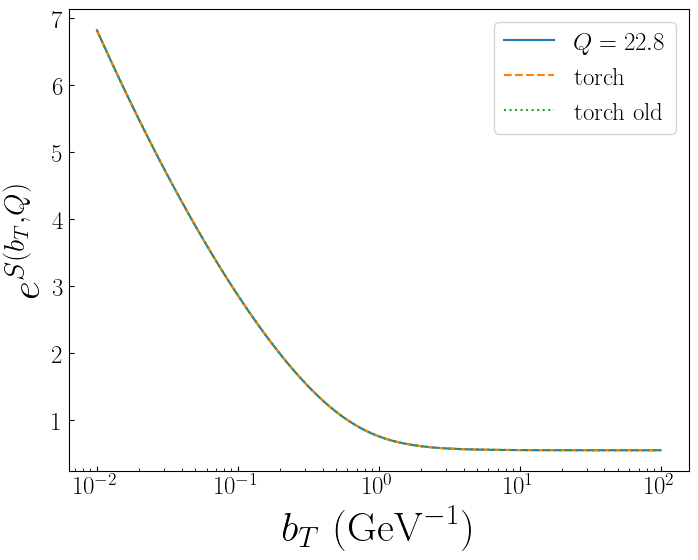

In [77]:
nrows,ncols = 1,1
py.figure(figsize=(8*ncols,6*nrows))
ax=py.subplot(nrows,ncols,1)

idx = 10
ax.plot(bTs,sud.T[idx],label=r'$Q=%.1f$'%Q[idx])
# ax.plot(bTs,sud_css.T[idx],'--',label=r'$\rm torch$')
ax.plot(bTs,torch.ones(len(bTs))*sud_css.T[idx],'--',label=r'$\rm torch$')
ax.plot(bTs,torch.ones(len(bTs))*sud_css_old.T[idx],':',label=r'$\rm torch~old$')
# ax.plot(bTs,sud.T[idx] / sud_css.T[idx])
# ax.plot(bTs,sud_css_old.T[idx] / sud_css.T[idx])
# ax.plot(bTs,sud_css.T[idx] - sud.T[idx],label=r'$\rm torch - numpy$')
ax.semilogx()
ax.set_xlabel(r'$b_T~({\rm GeV}^{-1})$',size=30)
ax.set_ylabel(r'$e^{S(b_T,Q)}$',size=30)
ax.tick_params(direction='in',labelsize=18,which='both',axis='both')
ax.legend(fontsize=18)
# ax.set_ylim(0.9,1.1)

In [49]:
torch.log(torch.tensor(0.1804/0.3550))

tensor(-0.6769)

In [ ]:
# gammas

In [ ]:
beta_prime.shape

(4, 4, 7)

In [ ]:
delta.shape

(4, 4, 7)

In [ ]:
class PERTURBATIVE_EVOLUTION_ANALYTIC:
    
    def __init__(self):
        aux=conf['aux']
        #self.order=conf['TMDorder'][1]
        if conf['tmd settings']['TMDorder']: # Set log order via conf['tmd settings']
            self.order=conf['tmd settings']['TMDorder'][1]

        
        if self.order=='LL': self.iorder=0
        elif self.order=='NLL': self.iorder=1
        elif self.order=='N2LL': self.iorder=2
        elif self.order=='N3LL': self.iorder=3

        self.CF=aux.CF
        self.CA=aux.CA
        self.TR=aux.TR
        self.TF=aux.TF
        self.zeta2 = zeta(2)
        self.zeta3 = zeta(3)
        self.zeta4 = zeta(4)
        self.zeta5 = zeta(5)
        self.tmd_model=conf['tmdmodel']
        self.alphaS=conf['alphaS']

        self.setup_beta_roots()


    #============================================================
    #--Setting up Gamma_cusp
    #============================================================
    """
    \$\Gamma\$-cusp

     notice the following correspondence from https://arxiv.org/pdf/1803.11089.pdf 

     Rogers17_PhysRevD.96.054011.pdf uses gamma_K = 2 gamma_Cusp
     - Cusp anomalous dimension expanded in alphaS, Eq. (59) of PhysRevD.96.054011
     https://inspirehep.net/literature/1452696 Appendix D notice that one should use \$\Gamma^{(n-1)}\$ in other parts 


    the 4-loop expression is taken from [2001.11377] (appendix C)
     """

    def get_Gamma0(self,Nf):
        """
        PCB checked consistency with artemide: 1/10/2025
        """
        #--aS**1
        #Nf=self.alphaS.get_Nf(mu**2)
        return 4. * self.CF

    def get_Gamma1(self,Nf):
        """
        PCB checked consistency with artemide: 1/10/2025
        """
        #--aS**2
        #Nf=self.alphaS.get_Nf(mu**2)
        return 4 * self.CF * (self.CA * (67/9 - np.pi**2/3)\
                   - 20/9 * self.TR * Nf)

    def get_Gamma2(self,Nf):
        """
        PCB checked consistency with artemide: 1/10/2025
        """
        #--aS**3
        #Nf=self.alphaS.get_Nf(mu**2)
        return 4 * self.CF *(self.CA**2 * (245/6 - 134/27*np.pi**2 + 11/45*np.pi**4 + 22/3*self.zeta3) \
                    + self.CA * self.TR * Nf * (-418/27 + 40/27*np.pi**2 - 56/3*self.zeta3)\
                    + self.CF * self.TR * Nf * (-55/3 + 16 * self.zeta3) - 16/27 * self.TR**2 * Nf**2 )

    def get_Gamma3(self,Nf):
        """
        PCB checked consistency with artemide: 1/10/2025
        """
        #--aS**4
        #Nf=self.alphaS.get_Nf(mu**2)
        dFA=15/16 #--d_F^{abcd}d_A^{abcd}/(N^2-1)
        dFF=5/96 #--d_F^{abcd}d_F^{abcd}/(N^2-1)

        return  self.CF*( \
                dFA*(7040/3*self.zeta5 +256/3*self.zeta3-768*(self.zeta3**2) -256*self.zeta2 -15872/35*(self.zeta2**3))\
                +dFF*Nf*(-2560/3*self.zeta5 -512/3*self.zeta3 +512*self.zeta2)\
                +(Nf**3)*(-32/81 +64/27*self.zeta3)\
                +self.CF*(Nf**2)*(2392/81 -640/9*self.zeta3 +64/5*(self.zeta2**2))\
                +(self.CF**2)*Nf*(572/9 -320*self.zeta5 +592/3*self.zeta3)\
                +self.CA*(Nf**2)*(923/81 +2240/27*self.zeta3 -608/81*self.zeta2 -224/15*(self.zeta2**2))\
                +self.CF*self.CA*Nf*(-34066/81 +160*self.zeta5 +3712/9*self.zeta3 +440/3*self.zeta2 -128*self.zeta2*self.zeta3 -352/5*(self.zeta2**2))\
                +(self.CA**2)*Nf*(-24137/81 +2096/9*self.zeta5 -23104/27*self.zeta3 +20320/81*self.zeta2 \
                +448/3*self.zeta2*self.zeta3 -352/15*(self.zeta2**2))\
                +(self.CA**3)*(84278/81 - 3608/9*self.zeta5 +20944/27*self.zeta3 -16*(self.zeta3**2) \
                -88400/81*self.zeta2 -352/3*self.zeta2*self.zeta3 +3608/5*(self.zeta2**2)-20032/105*(self.zeta2**3)))       



    #============================================================
    #--Setting up Rapidity Anomalous dimention as in https://inspirehep.net/literature/1770788
    #============================================================


    def get_RADresum(self, bT, mu):  
        """
        Perturbatively resummed RAD, (B.5)
        """
        aS=self.alphaS.get_a(mu**2) #- alphaS/(4 pi)
        Nf=self.alphaS.get_Nf(mu**2) #- Number of flavors
        
        order_resummation = self.iorder

        beta0 = self.alphaS.beta[Nf,0] #-beta function 
        beta1 = self.alphaS.beta[Nf,1] #-beta function 
        beta2 = self.alphaS.beta[Nf,2] #-beta function 
        beta3 = 2857/54 * self.CA**3 + (2*self.CF**2 - 205/9 * self.CF*self.CA - 1415/27 * self.CA**2) * self.TR*Nf +\
                (44/9 * self.CF + 158/27 * self.CA) * self.TR**2 * Nf**2        
        
            
        X = beta0 * aS * self.tmd_model.get_Lmu(bT,mu)
        
        gamma0 = self.get_Gamma0(Nf)
        
        RADresum = -gamma0/(2*beta0) * np.log(1-X)
        
           
        if order_resummation>0: 
            gamma1 = self.get_Gamma1(Nf)
           
            RADresum += aS * 1/(2*beta0*(1-X)) * (-beta1*gamma0/beta0 * (np.log(1-X)+X) + gamma1 * X) 
            
        if order_resummation>1:
            gamma2 = self.get_Gamma2(Nf)
            
            d20 = self.CF * ((404/27 - 14 * self.zeta3) * self.CA - 112/27 * self.TR * Nf)

            RADresum += aS**2 * 1/(1-X)**2 *( gamma0 * beta1**2/(4*beta0**3) * (np.log(1-X)**2 - X**2) + \
                                    beta1*gamma1/(4*beta0**2)*(X**2 - 2*X-2*np.log(1-X)) + \
                                    gamma0*beta2/(4*beta0**2)*X**2 - gamma2/(4*beta0) * X*(X-2) + d20)
            
        if order_resummation>2:
            gamma3 = self.get_Gamma3(Nf)
           
            d30 = self.CF* ( self.CA**2 * (297029/1458 - 3196/81*self.zeta2 - 6164/27 * self.zeta3 - 77/3 * self.zeta4 + 88/3 * self.zeta2 * self.zeta3 + 96 * self.zeta5) + \
                            self.CA * Nf * (-31313/729 + 412/81 * self.zeta2 + 452/27 * self.zeta3 - 10/3 * self.zeta4) + \
                            self.CF * Nf * (-1711/54 + 152/9 * self.zeta3 + 8 * self.zeta4) + \
                            Nf**2 * (928/729 + 16/9 * self.zeta3) )

            RADresum += aS**3 * 1/(1-X)**3 * ( -gamma0 * beta1**3/(6*beta0**4) * (np.log(1-X)**3 - 3/2 * np.log(1-X)**2 - 3 * np.log(1-X)*X + X**3 - 3/2 * X**2) + \
                                    beta1**2*gamma1/(2*beta0**3)*(np.log(1-X)**2 + 1/3* X**3 - X**2) - \
                                    beta2*beta1*gamma0/(2*beta0**3)*(X*np.log(1-X) + 2/3 * X**3 - X**2) - \
                                    beta1*gamma2/(2*beta0**2) * (np.log(1-X) + X**3/3 - X**2 + X) + \
                                    X**2/(12*beta0**2) * (beta3 * gamma0 * (3-2*X) + 2 * beta2 * gamma1 * (3-X)) + \
                                    gamma3/(6*beta0) * X*(3-3*X+X**2) - 2 * beta1 * d20/beta0 * np.log(1-X) + d30)

        #        self.storage[key]=RADresum
 
        return RADresum# self.storage[key]
 


    
    
    #============================================================
    #--Setting up gamma_V 
    #  https://inspirehep.net/literature/1452696 Appendix D
    #============================================================
    """
    Here we calculate the \$\gamma_{V}\$ https://inspirehep.net/literature/1452696 Appendix D
    """
    def get_gammaV1(self,Nf):
        """
        PCB checked consistency with artemide: 1/10/2025
        """
        #--aS**1
        # Nf=self.alphaS.get_Nf(mu**2)
        return -6. * self.CF

    def get_gammaV2(self,Nf):
        """
        PCB checked consistency with artemide: 1/10/2025
        """
        #--aS**2
        #Nf=self.alphaS.get_Nf(mu**2)
        return  self.CF**2 * (-3 + 4*np.pi**2 - 48*self.zeta3) + self.CF*self.CA*(-961/27-11*np.pi**2/3+52*self.zeta3) + \
                self.CF*self.TR*Nf*(260/27+4*np.pi**2/3.)

    def get_gammaV3(self,Nf):
        """
        PCB checked consistency with artemide: 1/10/2025
        """
        #--aS**3
        #Nf=self.alphaS.get_Nf(mu**2)
        
        CF = self.CF
        pi = np.pi
        zeta3 = self.zeta3
        zeta5 = self.zeta5
        CA = self.CA
        TR = self.TR
        
        return  CF**3 * (-29 - 6*pi**2 - 16/5*pi**4 - 136*zeta3 + 32*pi**2/3 * zeta3 + 480*zeta5) + \
            CF**2*CA *(-151/2 + 410/9*pi**2 + 494*pi**4/135 - 1688/3*zeta3 - 16/3*pi**2*zeta3 - 240*zeta5) + \
            CF*CA**2 *(-139345/1458-7163/243*pi**2-83/45*pi**4+7052/9*zeta3-88/9*pi**2*zeta3-272*zeta5)+\
            CF**2*TR*Nf*(5906/27-52/9*pi**2-56/27*pi**4+1024/9*zeta3) + \
            CF*CA*TR*Nf*(-34636/729+5188/243*pi**2+44/45*pi**4-3856/27*zeta3) +  \
            CF*TR**2*Nf**2*(19336/729-80/27*pi**2-64/27*zeta3)


    #============================================================
    #-- Here we calculate zeta_mu
    #============================================================
    """
    https://inspirehep.net/literature/1770788 (2.91) where
    zeta_mu exact is (C.9)
    and (notice exp(-v) should be used) in (C.3)
    """  
     
    def get_zetaMuPert(self, bT, mu):
        aS=self.alphaS.get_a(mu**2) #- alphaS/(4 pi)
        #aS=conf['dy_qT'].OPEA.pdf.alphasQ2(mu**2) / (4*np.pi)
        Nf=self.alphaS.get_Nf(mu**2) #- Number of flavors
        #Nf=5 #- Number of flavors
        # Nf = conf['dy_qT'].OPEA.pdf.numFlavorsQ2(mu**2)
        
        order_resummation = self.iorder
        
        CF = self.CF
        CA = self.CF
        pi = np.pi
        zeta2 = self.zeta2
        zeta3 = self.zeta3
        zeta4 = self.zeta4
        zeta5 = self.zeta5
        TR = self.TR


        beta0 = self.alphaS.beta[Nf,0] #-beta function 
        beta1 = self.alphaS.beta[Nf,1] #-beta function 
        beta2 = self.alphaS.beta[Nf,2] #-beta function 
        beta3 = 2857/54 * self.CA**3 + (2*self.CF**2 - 205/9 * self.CF*self.CA - 1415/27 * self.CA**2) * self.TR*Nf +\
                (44/9 * self.CF + 158/27 * self.CA) * self.TR**2 * Nf**2        
        Lmu = self.tmd_model.get_Lmu(bT, mu)
        
        gamma0 = self.get_Gamma0(Nf)
        
        GAMMA1 = self.get_gammaV1(Nf)
        
        v = GAMMA1/gamma0
           
        if order_resummation>1: 
            GAMMA2 = self.get_gammaV2(Nf)
            gamma1 = self.get_Gamma1(Nf)
            
            d20 = CF * ((404/27 - 14 * zeta3) * CA - 112/27 * TR *Nf)

         
            v += aS * (beta0/12*Lmu**2  - GAMMA1*gamma1/gamma0**2 + (GAMMA2 + d20)/gamma0)
            
        if order_resummation>2:
            GAMMA3 = self.get_gammaV3(Nf)
            gamma2 = self.get_Gamma2(Nf)

          
            d30 = CF* ( CA**2 * (297029/1458 - 3196/81*zeta2 - 6164/27 * zeta3 - 77/3 * zeta4 + 88/3 * zeta2 * zeta3 + 96 * zeta5) + \
                            CA * Nf * (-31313/729 + 412/81 * zeta2 + 452/27 * zeta3 - 10/3 * zeta4) + \
                            CF * Nf * (-1711/54 + 152/9 * zeta3 + 8 * zeta4) + \
                            Nf**2 * (928/729 + 16/9 * zeta3) )



            v+= aS**2 * (beta0**2/24 * Lmu**3 + (beta1/12 + beta0*gamma1/gamma0) * Lmu**2 + \
                                (beta0 * GAMMA2/(2*gamma0) + 4 * beta0 * d20/(3*gamma0) - beta0 * GAMMA1 * gamma1/(2*gamma0**2)) * Lmu + \
                                GAMMA1 * gamma1**2/gamma0**3 - (GAMMA1 * gamma2 + GAMMA2 * gamma1 + d20 * gamma1)/gamma0**2 + (GAMMA3 + d30)/gamma0 ) 
  
            
        return mu/bT * self.tmd_model.C1 * np.exp(-v)  
    
    

    def get_g(self, mu, D):
        aS=self.alphaS.get_a(mu**2) #- alphaS/(4 pi)
        #--aS=conf['dy_qT'].OPEA.pdf.alphasQ2(mu**2) / (4*np.pi)
        #Nf=self.alphaS.get_Nf(mu**2) #- Number of flavors
        #Nf=5 #- Number of flavors
        Nf = self.alphaS.get_Nf(mu**2)
        
        order_resummation = self.iorder

        
        """
        PCB checked consistency of the beta functions (up to and including beta2)
        in our JAM alphaS with artemide: 1/10/2025
        """
        beta0 = self.alphaS.beta[Nf,0] #-beta function 
        beta1 = self.alphaS.beta[Nf,1] #-beta function 
        beta2 = self.alphaS.beta[Nf,2] #-beta function 
        beta3 = 2857/54 * self.CA**3 + (2*self.CF**2 - 205/9 * self.CF*self.CA - 1415/27 * self.CA**2) * self.TR*Nf +\
                (44/9 * self.CF + 158/27 * self.CA) * self.TR**2 * Nf**2
        
        gamma0 = self.get_Gamma0(Nf)
    

        """
        PCB checked these functions against SV19 up to aS**2, which are the same as what is in the artemide code: 1/17/2025
        """
        p = 2 * beta0 * D/gamma0
                       
        g = np.exp(-p) - 1 + p
           
        if order_resummation>0:            
            
            GAMMA1 = self.get_gammaV1(Nf)
            gamma1 = self.get_Gamma1(Nf)
            
            # Notice typo in C.14 in the last term \gamma_0 -> \Gamma_0 in the denominator
            g += aS * (beta1/beta0 * (np.exp(-p) - 1 + p - p**2/2)  - gamma1/gamma0 * (np.exp(-p) - 1 + p) + \
                       beta0 * GAMMA1/gamma0 * p)

            
        if order_resummation>1:
            GAMMA2 = self.get_gammaV2(Nf)
            gamma2 = self.get_Gamma2(Nf)
            
 
            g+= aS**2 * ( (gamma1**2/gamma0**2-gamma2/gamma0) * (np.cosh(p) - 1) + \
                         (beta1*gamma1/(beta0*gamma0)-beta2/beta0) * (np.sinh(p) - p) + \
                         (beta0 * GAMMA2/gamma0 - beta0*GAMMA1*gamma1/gamma0**2)*(np.exp(p)-1)
                        )
                
        if order_resummation>20: # AP - need more work on as^3 as one needs to add as^4 to make it stable
            GAMMA3 = self.get_gammaV3(Nf)
            gamma3 = self.get_Gamma3(Nf)

            g+= aS**3 * ( (beta1*(beta1*gamma1-beta2*gamma0)/(12*beta0**2*gamma0) - \
                           (beta3*gamma0-2*beta2*gamma1+beta1*gamma2)/(12*beta0*gamma0) - \
                           gamma1**3/(3*gamma0) -gamma1*gamma2/(2*gamma0**2) - gamma3/(6*gamma0)) * (np.exp(2*p)+2*np.exp(-p)-3) + \
                           (gamma1**3/gamma0**3-gamma1*gamma2/gamma0**2-beta2*gamma1/(beta0*gamma0)) * (np.cosh(p) - 1) + \
                           beta0/gamma0*(GAMMA1*gamma1**2/gamma0**2-GAMMA2*gamma1/gamma0-GAMMA1*gamma2/gamma0+GAMMA3)*np.exp(p)*(np.exp(p)-1) + \
                           (beta1*GAMMA2/gamma0 - beta1*gamma1*GAMMA1/gamma0**2 - beta0*GAMMA3/gamma0 + beta0*GAMMA1*gamma2/gamma0**2)*1/2*(np.exp(p)-1)**2 + \
                           beta3/(2*beta0)*(np.exp(-p) + p -1) + \
                           beta1/(2*beta0)*(beta2/beta0-beta1*gamma1/(beta0*gamma0) + gamma2/gamma0) * (np.exp(p) - p -1)  \
                        )
                        


        return 1/aS * gamma0/(2*beta0**2) * g

    
    #============================================================
    #--Setting up Rapidity Anomalous dimention as in https://inspirehep.net/literature/2659271
    # Eq. (2.30) or Eq. (B2) from https://inspirehep.net/literature/1770788
    #============================================================
    
    
    def get_RADpert(self, bTs, mus, Nf):  
        """
        Perturbative RAD, (B.2) or (2.30) (notice the typo in summation n =1)
        """
        aS=np.array([self.alphaS.get_a(_**2) for _ in mus]) #- alphaS/(4 pi)
        #aS=np.array([conf['dy_qT'].OPEA.pdf.alphasQ2(_**2) for _ in mus])/ (4*np.pi)
        # aS =2.9469093812788567E-002
        
        
        order_resummation = self.iorder
        
        Log=self.tmd_model.get_Lmu(bTs, mus) # Typical log

                  
        RADpert = 0.
        
        if order_resummation>0: 
            
            d10 = 0.
            d11 = 0. # FILL IN THE VALUE! I JUST SET IT TO ZERO
           
            RADpert += aS * (d10 + Log * d11)
            
        if order_resummation>1:
            
            d20 = self.CF * ((404/27 - 14 * self.zeta3) * self.CA - 112/27 * self.TR * Nf)
            d21 = 0. # FILL IN THE VALUE! I JUST SET IT TO ZERO
            d22 = 0. # FILL IN THE VALUE! I JUST SET IT TO ZERO

            RADpert += aS**2 * (d20 + Log * d21 + Log**2 * d22)
            
        if order_resummation>2:
           
            d30 = self.CF* ( self.CA**2 * (297029/1458 - 3196/81*self.zeta2 - 6164/27 * self.zeta3 - 77/3 * self.zeta4 + 88/3 * self.zeta2 * self.zeta3 + 96 * self.zeta5) + \
                            self.CA * Nf * (-31313/729 + 412/81 * self.zeta2 + 452/27 * self.zeta3 - 10/3 * self.zeta4) + \
                            self.CF * Nf * (-1711/54 + 152/9 * self.zeta3 + 8 * self.zeta4) + \
                            Nf**2 * (928/729 + 16/9 * self.zeta3) )

            d31 = 0. # FILL IN THE VALUE! I JUST SET IT TO ZERO
            d32 = 0. # FILL IN THE VALUE! I JUST SET IT TO ZERO
            d33 = 0. # FILL IN THE VALUE! I JUST SET IT TO ZERO

            
            RADpert += aS**3 * (d30 + Log * d31 + Log**2 * d32 + Log**2 * d33)

        #        self.storage[key]=RADresum
 
        return RADpert# self.storage[key]


    def get_gammaCusp(self,mu,Nf):
        """
        Cusp anomalous dimension expanded in alphaS, Eq. (2.16)) of  https://inspirehep.net/literature/2659271
        """

        aS=conf['alphaS'].get_a(mu**2) #- alphaS/(4 pi)
        #aS=conf['dy_qT'].OPEA.pdf.alphasQ2(mu**2) / (4*np.pi)

        gamma0 = self.get_Gamma0(Nf)        
        gammaCusp = gamma0 * aS

        if self.iorder>0: 
            gamma1 = self.get_Gamma1(Nf)
            gammaCusp += aS**2 * gamma1

        if self.iorder>1:
            gamma2 = self.get_Gamma2(Nf)
            gammaCusp += aS**3 *  gamma2

        if self.iorder>2:
            gamma3 = self.get_Gamma3(Nf)
            gammaCusp += aS**4 *  gamma3

        return gammaCusp


    def get_integrand_gammaCusp(self,mup,Nf):
        """
        Returns 1/mu'GammaCusp(mu') needed for the integral in get_Sudakov_perturbative
        See Eq. (2.16) for the definition of GammaCusp
        """
                
        return 1/mup*self.get_gammaCusp(mup,Nf)


    def get_analytic_Sudakov(self,mu0,muf,Nf):
        #--here we assume an integral from mu0 to muf

        #conf['dy_qT'].OPEA.pdf.alphasQ2(mu**2)
        alphaS_f = self.alphaS.get_alphaS(muf**2)
        alphaS_0 = self.alphaS.get_alphaS(mu0**2)
        #alphaS_f = conf['dy_qT'].OPEA.pdf.alphasQ2(muf**2)
        #alphaS_0 = conf['dy_qT'].OPEA.pdf.alphasQ2(mu0**2)
        
        gamma0 = self.get_Gamma0(Nf)
        beta0  = self.alphaS.beta[Nf,0]

        #--LL
        if self.iorder==0:
            intgl = -1/2 * (gamma0 / beta0 * np.log(alphaS_f/alphaS_0))

        #--NLL
        elif self.iorder==1:
            gamma1 = self.get_Gamma1(Nf)
            beta1  = self.alphaS.beta[Nf,1]

            delta1 = self.delta[1][1][Nf]

            Gamma = gamma0 * delta1 + gamma1 * delta1**2
            betaprime = -2 * (2 * beta0 * delta1 + 3 * beta1 * delta1**2)

            intgl = -1/2 * (gamma0 / beta0 * np.log(alphaS_f/alphaS_0)\
                           -2 * Gamma / betaprime * np.log((alphaS_f - 4 * np.pi * delta1)/(alphaS_0 - 4 * np.pi * delta1)))

        #--N2LL
        elif self.iorder==2:

            gamma1 = self.get_Gamma1(Nf)
            gamma2 = self.get_Gamma2(Nf)

            beta1 = self.alphaS.beta[Nf,1]
            beta2 = self.alphaS.beta[Nf,2]

            delta1 = self.delta[2][1][Nf]
            delta2 = self.delta[2][2][Nf]
            
            Gamma_delta1 = gamma0 * delta1 + gamma1 * delta1**2 + gamma2 * delta1**3
            Gamma_delta2 = gamma0 * delta2 + gamma1 * delta2**2 + gamma2 * delta2**3

            betaprime_delta1 = -2 * (2 * beta0 * delta1 + 3 * beta1 * delta1**2 + 4 * beta2 * delta1**3)
            betaprime_delta2 = -2 * (2 * beta0 * delta2 + 3 * beta1 * delta2**2 + 4 * beta2 * delta2**3)

            intgl = -1/2 * (gamma0 / beta0 * np.log(alphaS_f/alphaS_0)\
                           -2 * Gamma_delta1 / betaprime_delta1 * np.log((alphaS_f - 4 * np.pi * delta1)/(alphaS_0 - 4 * np.pi * delta1))\
                           -2 * Gamma_delta2 / betaprime_delta2 * np.log((alphaS_f - 4 * np.pi * delta2)/(alphaS_0 - 4 * np.pi * delta2)))

        #--N3LL
        elif self.iorder==3:

            gamma1 = self.get_Gamma1(Nf)
            gamma2 = self.get_Gamma2(Nf)
            gamma3 = self.get_Gamma3(Nf)

            beta1 = self.alphaS.beta[Nf,1]
            beta2 = self.alphaS.beta[Nf,2]
            if len(self.alphaS.beta[Nf])==3:
                beta3 = 29243.0 - 6946.30 * Nf + 405.089 * Nf**2 + 1093/729 * Nf**3

            delta1 = self.delta[3][1][Nf]
            delta2 = self.delta[3][2][Nf]
            delta3 = np.real(self.delta[3][3][Nf]) #--this should be a real number, so I just take the real value of it.

            Gamma_delta1 = gamma0 * delta1 + gamma1 * delta1**2 + gamma2 * delta1**3 + gamma3 * delta1**4
            Gamma_delta2 = gamma0 * delta2 + gamma1 * delta2**2 + gamma2 * delta2**3 + gamma3 * delta2**4
            Gamma_delta3 = gamma0 * delta3 + gamma1 * delta3**2 + gamma2 * delta3**3 + gamma3 * delta3**4

            betaprime_delta1 = -2 * (2 * beta0 * delta1 + 3 * beta1 * delta1**2 + 4 * beta2 * delta1**3 + 5 * beta3 * delta1**4)
            betaprime_delta2 = -2 * (2 * beta0 * delta2 + 3 * beta1 * delta2**2 + 4 * beta2 * delta2**3 + 5 * beta3 * delta2**4)
            betaprime_delta3 = -2 * (2 * beta0 * delta3 + 3 * beta1 * delta3**2 + 4 * beta2 * delta3**3 + 5 * beta3 * delta3**4)

            intgl = -1/2 * (gamma0 / beta0 * np.log(alphaS_f/alphaS_0)\
                           -2 * Gamma_delta1 / betaprime_delta1 * np.log((alphaS_f - 4 * np.pi * delta1)/(alphaS_0 - 4 * np.pi * delta1))\
                           -2 * Gamma_delta2 / betaprime_delta2 * np.log((alphaS_f - 4 * np.pi * delta2)/(alphaS_0 - 4 * np.pi * delta2))\
                           -2 * Gamma_delta3 / betaprime_delta3 * np.log((alphaS_f - 4 * np.pi * delta3)/(alphaS_0 - 4 * np.pi * delta3)))
        
        
        return np.real(intgl)
            
    
    def get_Sudakov_perturbative(self,mub,mu,method='analytic'):
        """
        perturbative part of the evolution in the solution 
        maximizing perturbative precision, 
        Eq. (2.33) of https://inspirehep.net/literature/2659271
        Returns perturbative Sudakov using b* and mub* 
        """
        #Nf=5#self.alphaS.get_Nf(mu**2) #- Number of flavors
        Nf=self.alphaS.get_Nf(mu**2) #- Number of flavors

        key = 'mu=%.6f,mub=%.6f'%(mu,mub)
        if key not in self.storage_Sudakov:
            if method=='numeric':
                self.storage_Sudakov[key]=quad(lambda mup: self.get_integrand_gammaCusp(mup,Nf),mub,mu)[0]
            elif method =='analytic':
                #--this is under the assumption of integration from mub up to mu.
                intgl=0
                Nf_mub = self.alphaS.get_Nf(mub**2)
                Nf_mu  = self.alphaS.get_Nf(mu**2)
                
                if Nf_mub==4 and Nf_mu==5:
                    intgl += self.get_analytic_Sudakov(mub,conf['aux'].mb,Nf=4)
                    intgl += self.get_analytic_Sudakov(conf['aux'].mb,mu,Nf=5)
                elif Nf_mub==5 and Nf_mu==4:
                    intgl += self.get_analytic_Sudakov(mub,conf['aux'].mb,Nf=5)
                    intgl += self.get_analytic_Sudakov(conf['aux'].mb,mu,Nf=4)
                elif Nf_mub==3 and Nf_mu==4:
                    intgl += self.get_analytic_Sudakov(mub,conf['aux'].mc,Nf=3)
                    intgl += self.get_analytic_Sudakov(conf['aux'].mc,mu,Nf=4)
                elif Nf_mub==3 and Nf_mu==5:
                    intgl += self.get_analytic_Sudakov(mub,conf['aux'].mc,Nf=3)
                    intgl += self.get_analytic_Sudakov(conf['aux'].mc,conf['aux'].mb,Nf=4)
                    intgl += self.get_analytic_Sudakov(conf['aux'].mb,mu,Nf=5)
                elif Nf_mub == Nf_mu:
                    intgl += self.get_analytic_Sudakov(mub,mu,Nf=Nf_mub)
                else:
                    print('no computation')
    
                self.storage_Sudakov[key] = intgl
        return self.storage_Sudakov[key]
    


In [ ]:
from tools.tools import interpolate

In [ ]:
bTs = torch.tensor(bTs,dtype=torch.float64)
Q = torch.tensor(Q,dtype=torch.float64)
sud = torch.tensor(sud,dtype=torch.float64)

In [ ]:
bTs_new = 10**torch.linspace(-1.8,1.8,200,dtype=torch.float64)
interped =  interpolate(bTs,bTs_new,'cubic-turbo',device,torch.float64)

sud0 = sud.T[0]

sud_mod = torch.einsum('jb,b->j',interped,sud0)


In [ ]:
# interped

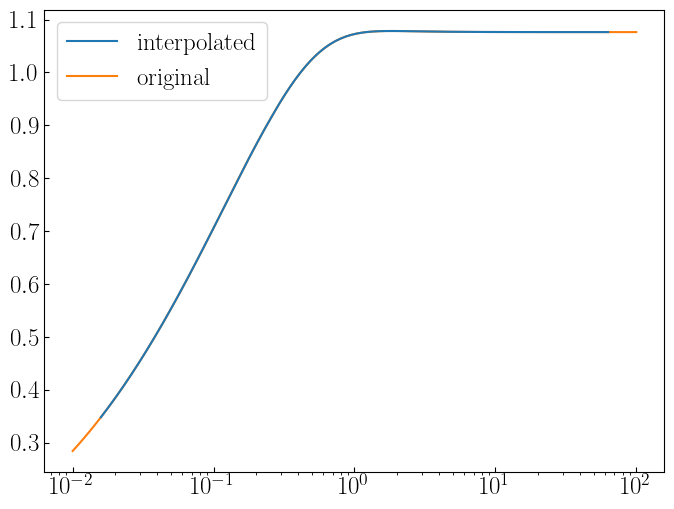

In [ ]:
nrows,ncols=1,1
py.figure(figsize=(8*ncols,6*nrows))
ax = py.subplot(nrows,ncols,1)

ax.plot(bTs_new,sud_mod,label=r'$\rm interpolated$',zorder=10)
ax.plot(bTs,sud0,label=r'$\rm original$')
ax.tick_params(direction='in',labelsize=18)
ax.semilogx()
ax.legend(fontsize=18)

In [ ]:
Q_new = torch.linspace(3,10,300,dtype=torch.float64)
bTs_new = 10**torch.linspace(-2,2,500,dtype=torch.float64)

In [ ]:
interpbT = interpolate(bTs,bTs_new,'cubic-turbo',device,torch.float64)
interpQ  = interpolate(Q,Q_new,'cubic-turbo',device,torch.float64)

In [ ]:
print(interpbT.shape,interpQ.shape,sud.shape)

torch.Size([500, 100]) torch.Size([300, 50]) torch.Size([100, 50])


In [ ]:
sud_new = torch.einsum('ib,bQ,jQ->ij',interpbT,sud,interpQ)

Text(0.4, 0.1, '$b_T=10.72~{\\rm GeV}^{-1}$')

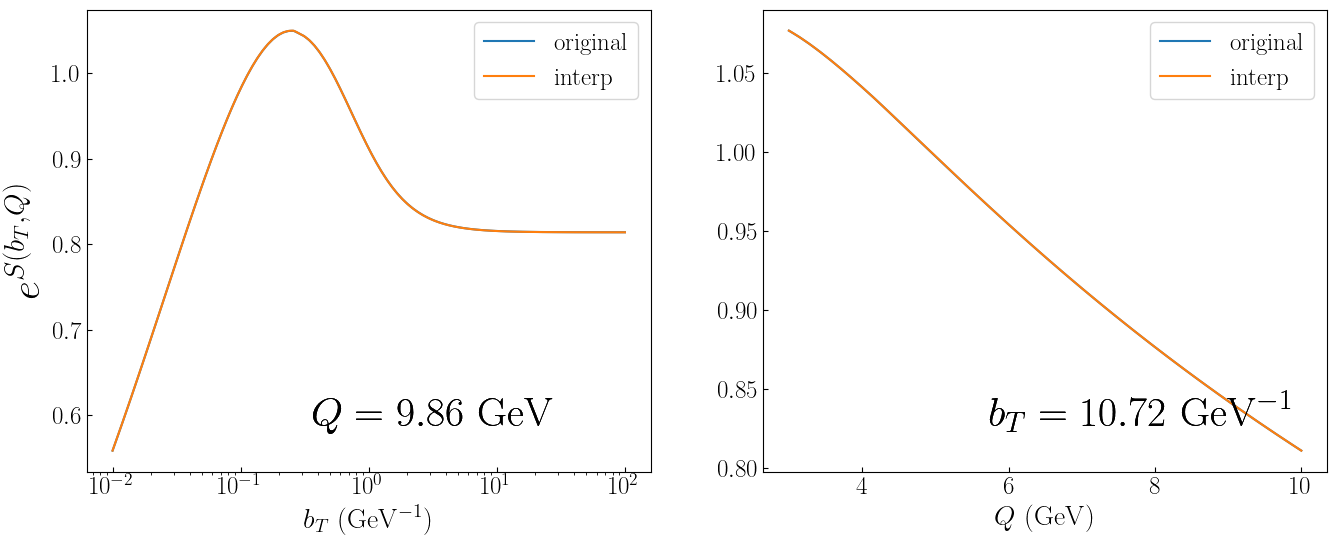

In [ ]:
nrows,ncols=1,2
py.figure(figsize=(8*ncols,6*nrows))
ax = py.subplot(nrows,ncols,1)

# ax.plot(x_new[x_new>1],sud_mod[x_new>1],label=r'$\rm interpolated$')
# ax.plot(x_old[x_old>1],sud0[x_old>1],label=r'$\rm original$')

idx=-2
ax.plot(bTs,sud.T[idx],label=r'\rm original')
ax.text(0.4,0.1,r'$Q=%.2f~{\rm GeV}$'%Q[idx],transform=ax.transAxes,size=30)

idx = -7
ax.plot(bTs_new,sud_new.T[idx],label=r'$\rm interp$')
ax.tick_params(direction='in',labelsize=18)
ax.semilogx()
ax.legend(fontsize=18)
ax.set_xlabel(r'$b_T~({\rm GeV}^{-1})$',size=20)
ax.set_ylabel(r'$e^{S(b_T,Q)}$',size=30)
ax.text(0.4,0.1,r'$Q=%.2f~{\rm GeV}$'%Q_new[idx],transform=ax.transAxes,size=30)

ax=py.subplot(nrows,ncols,2)

idx=75
ax.plot(Q,sud[idx],label=r'$\rm original$')
ax.text(0.4,0.1,r'$b_T=%.2f~{\rm GeV}^{-1}$'%bTs[idx],transform=ax.transAxes,size=30)
idx=378
ax.plot(Q_new,sud_new[idx],label=r'$\rm interp$')
ax.tick_params(direction='in',labelsize=18)
ax.legend(fontsize=18)
ax.set_xlabel(r'$Q~({\rm GeV})$',size=20)
ax.text(0.4,0.1,r'$b_T=%.2f~{\rm GeV}^{-1}$'%bTs_new[idx],transform=ax.transAxes,size=30)


# Integration over $b_T$

## First take the Hankel transform of a known function
## $\int_0^\infty db_T b_T J_0(b_T q_T) K_0(n b_T) = \frac{1}{(n^2 + k_T^2)}$

In [29]:
def integrand(bT,qT):
    func = kv(0,2*bT)
    return bT * jv(0,bT * qT) * func
def integrand2(bT,qt):
    func = np.exp(0.01j*bT)/bT
    return bT*func*jv(0,bT*qt)

/home/joey/anaconda3/lib/python3.9/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


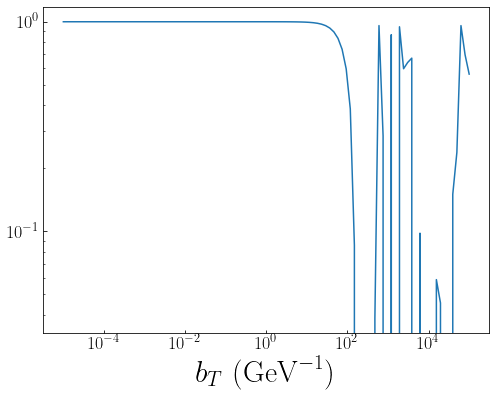

In [31]:
nrows,ncols = 1,1
py.figure(figsize=(8*ncols,6*nrows))

ax=py.subplot(nrows,ncols,1)

bTs = 10**np.linspace(-5,5,100)
qT = 0.0

intgd2 = integrand2(bTs,qT)
ax.plot(bTs,intgd2)
ax.semilogy()
ax.semilogx()
# ax.semilogy()
ax.set_xlabel(r'$b_T~({\rm GeV}^{-1})$',size=30)
ax.tick_params(direction='in',labelsize=18,which='both',axis='both')

In [24]:
def analytic_func(qT):
    return 1 / (4 + qT**2)
def analytic_func2(qT):
    return 1/np.sqrt(qT**2-0.01**2)

In [25]:
def get_WZ(bTnodes,pT,precision=1e-6):

    quad_precision = precision

    bTmax =100

    bTmin =1e-6
    if len(bTnodes)==0 or len(bTnodes)==1:
        W=quad(lambda bT: integrand2(bT,pT),bTmin,bTmax,epsrel=quad_precision)[0]
    else:
        flag='calculating'
        W=quad(lambda bT: integrand2(bT,pT),bTmin,bTnodes[1],epsrel=quad_precision)[0]
        if W==0:
            return 0.0
        for i in range(len(bTnodes)-1):
            #--i==even: negative integrand
            #--i==odd: positive integrand
            if i==0 or i==1: continue
            if flag=='finished': continue
            if i%2==0: continue
            intgrl=quad(lambda bT: integrand2(bT,pT),bTnodes[i-2],bTnodes[i],epsrel=quad_precision)[0]
            W+=intgrl
            if np.abs(intgrl/W) < precision: flag='finished'
        if flag!='finished':
            if len(bTnodes)%2==1:
                W+=quad(lambda bT: integrand2(bT,pT),bTnodes[-2],bTmax,epsrel=quad_precision)[0]
            else:
                W+=quad(lambda bT: integrand2(bT,pT),bTnodes[-1],bTmax,epsrel=quad_precision)[0]

    return W

In [26]:
largest_nodes=jn_zeros(0,1000)

qTs = np.linspace(1e-3,10,100)
bmax = 100

numeric=[]
for qt in qTs:
    bTnodes = largest_nodes[largest_nodes/(qt) < bmax]/(qt)
    numeric.append(get_WZ(bTnodes,qt,1e-20))
numeric=np.array(numeric)

analytic = analytic_func2(qTs)
print(analytic)

[       nan 9.85138008 4.93209626 3.29125484 2.46988882 1.97667064
 1.64767007 1.41257029 1.23618839 1.09896746 0.98916807 0.89931694
 0.82443032 0.76105705 0.70673143 0.65964496 0.61844102 0.58208204
 0.54976092 0.5208404  0.49481061 0.47125877 0.44984711 0.43029658
 0.41237464 0.39588592 0.38066511 0.36657138 0.353484   0.34129892
 0.32992591 0.31928643 0.30931172 0.29994136 0.29112205 0.28280656
 0.27495292 0.2675237  0.26048538 0.25380792 0.24746426 0.24142996
 0.23568295 0.23020319 0.22497245 0.21997414 0.2151931  0.21061546
 0.20622853 0.20202061 0.19798099 0.19409974 0.19036775 0.18677657
 0.18331836 0.17998589 0.17677242 0.17367168 0.17067784 0.16778547
 0.1649895  0.16228519 0.15966809 0.15713407 0.15467923 0.1522999
 0.14999267 0.1477543  0.14558175 0.14347217 0.14142285 0.13943126
 0.13749497 0.13561173 0.13377938 0.13199589 0.13025933 0.12856786
 0.12691976 0.12531338 0.12374716 0.1222196  0.12072929 0.11927489
 0.11785512 0.11646875 0.11511462 0.11379161 0.11249866 0.11123

/tmp/ipykernel_28376/4276074570.py:4: RuntimeWarning: invalid value encountered in sqrt
  return 1/np.sqrt(qT**2-0.01**2)


In [27]:
rel_err = (numeric - analytic) / analytic

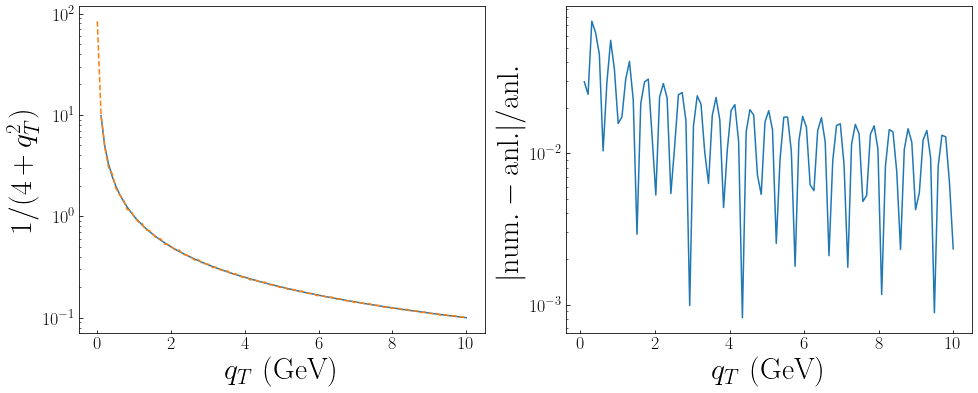

In [28]:
nrows,ncols=1,2
py.figure(figsize=(8*ncols,6*nrows))

ax=py.subplot(nrows,ncols,1)
ax.plot(qTs,analytic,label=r'$\rm analytic$')
ax.plot(qTs,numeric,'--',label=r'$\rm numeric$')
ax.set_xlabel(r'$q_T~({\rm GeV})$',size=30)
ax.set_ylabel(r'$1/(4 + q_T^2)$',size=30)
ax.tick_params(direction='in',labelsize=18,which='both',axis='both')
ax.semilogy()

ax=py.subplot(nrows,ncols,2)
ax.plot(qTs,np.abs(rel_err))
ax.set_xlabel(r'$q_T~({\rm GeV})$',size=30)
ax.set_ylabel(r'$\rm |num. - anl.|/anl.$',size=30)
ax.semilogy()
ax.tick_params(direction='in',labelsize=18,which='both',axis='both')

In [124]:
from scipy import fft
mu = 0.0                     # Order mu of Bessel function
b = np.logspace(-7, 1, 128*4)  # Input evaluation points
dln = np.log(b[1]/b[0])      # Step size
offset = fft.fhtoffset(dln, initial=-6*np.log(10), mu=mu)
qTs = np.exp(offset)/b[::-1]   # Output evaluation points

In [125]:
def ac(bT,n):
    return bT * kv(0,n*bT)

In [126]:
a_c = ac(b, 2)
fht = fft.fht(a_c, dln, mu=mu, offset=offset)

In [131]:
At = fht / qTs

In [132]:
largest_nodes=jn_zeros(0,1000)

#qTs = np.linspace(1e-3,10,100)
bmax = 100

numeric=[]
for qt in qTs:
    bTnodes = largest_nodes[largest_nodes/(qt) < bmax]/(qt)
    numeric.append(get_WZ(bTnodes,qt,1e-20))
numeric=np.array(numeric)

analytic = analytic_func(qTs)

In [133]:
rel_err_quad = (numeric - analytic) / analytic
rel_err_fht = (At - analytic) / analytic

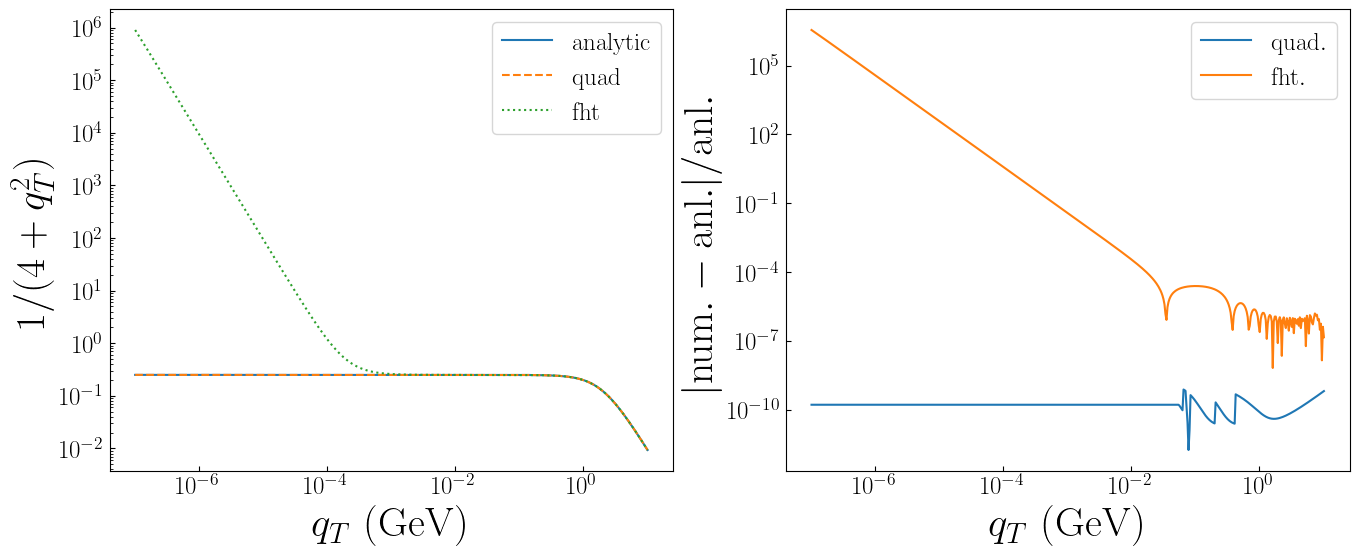

In [134]:
nrows,ncols=1,2
py.figure(figsize=(8*ncols,6*nrows))

ax=py.subplot(nrows,ncols,1)
ax.plot(qTs,analytic,label=r'$\rm analytic$')
ax.plot(qTs,numeric,'--',label=r'$\rm quad$')
ax.plot(qTs,At,':',label=r'$\rm fht$')
ax.set_xlabel(r'$q_T~({\rm GeV})$',size=30)
ax.set_ylabel(r'$1/(4 + q_T^2)$',size=30)
ax.tick_params(direction='in',labelsize=18,which='both',axis='both')
ax.semilogy()
ax.semilogx()
ax.legend(fontsize=18)

ax=py.subplot(nrows,ncols,2)
ax.plot(qTs,np.abs(rel_err_quad),label=r'$\rm quad.$')
ax.plot(qTs,np.abs(rel_err_fht),label=r'$\rm fht.$')
ax.set_xlabel(r'$q_T~({\rm GeV})$',size=30)
ax.set_ylabel(r'$\rm |num. - anl.|/anl.$',size=30)
ax.semilogy()
ax.semilogx()
ax.tick_params(direction='in',labelsize=18,which='both',axis='both')
ax.legend(fontsize=18)

## Try with the TMDs
## $\int_0^\infty db_T b_T J_0(b_T q_T) \tilde{f}(x,Q,b_T) = f(x,Q,k_T)$

In [33]:
def integrand(bT,x,Q,qT):
    # func = kv(0,2*bT)
    fNP = np.exp(-0.2 * bT**2)

    #--up quark
    func = ope.get_OPE_TMDPDF(x,bT)[1] * pertevo.get_exp_Sudakov_perturbative(Q,bT) * fNP
    
    return bT * jv(0,bT * qT) * func

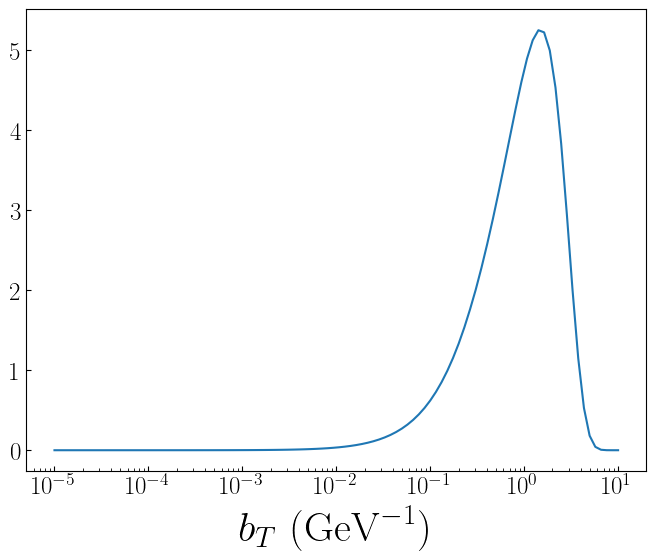

In [34]:
nrows,ncols = 1,1
py.figure(figsize=(8*ncols,6*nrows))

ax=py.subplot(nrows,ncols,1)

bTs = 10**np.linspace(-5,1,100)
x = 0.1
Q = 10
qT = 0.0

intgd = np.array([integrand(_,x,Q,qT) for _ in bTs])
ax.plot(bTs,intgd)
ax.semilogx()
# ax.semilogy()
ax.set_xlabel(r'$b_T~({\rm GeV}^{-1})$',size=30)
ax.tick_params(direction='in',labelsize=18,which='both',axis='both')

In [35]:
def get_WZ(bTnodes,x,Q,pT,precision=1e-6):

    quad_precision = precision

    bTmax =10

    bTmin =1e-6
    if len(bTnodes)==0 or len(bTnodes)==1:
        W=quad(lambda bT: integrand(bT,x,Q,pT),bTmin,bTmax,epsrel=quad_precision)[0]
    else:
        flag='calculating'
        W=quad(lambda bT: integrand(bT,x,Q,pT),bTmin,bTnodes[1],epsrel=quad_precision)[0]
        if W==0:
            return 0.0
        for i in range(len(bTnodes)-1):
            #--i==even: negative integrand
            #--i==odd: positive integrand
            if i==0 or i==1: continue
            if flag=='finished': continue
            if i%2==0: continue
            intgrl=quad(lambda bT: integrand(bT,x,Q,pT),bTnodes[i-2],bTnodes[i],epsrel=quad_precision)[0]
            W+=intgrl
            if np.abs(intgrl/W) < precision: flag='finished'
        if flag!='finished':
            if len(bTnodes)%2==1:
                W+=quad(lambda bT: integrand(bT,x,Q,pT),bTnodes[-2],bTmax,epsrel=quad_precision)[0]
            else:
                W+=quad(lambda bT: integrand(bT,x,Q,pT),bTnodes[-1],bTmax,epsrel=quad_precision)[0]

    return W

In [ ]:
largest_nodes=jn_zeros(0,1000)

qTs = np.linspace(1e-3,10,50)
bmax = 10
x = 0.1
Q = 100
numeric=[]
for i in range(len(qTs)):
    # print(i)
    qt = qTs[i]
    bTnodes = largest_nodes[largest_nodes/(qt) < bmax]/(qt)
    numeric.append(get_WZ(bTnodes,x,Q,qt,1e-20))
numeric=np.array(numeric)

/scratch/slurm/34112562/.cache/tmp/ipykernel_3300615/1130984758.py:9: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  W=quad(lambda bT: integrand(bT,x,Q,pT),bTmin,bTmax,epsrel=quad_precision)[0]
/scratch/slurm/34112562/.cache/tmp/ipykernel_3300615/1130984758.py:12: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain

In [ ]:
# rel_err = (numeric - analytic) / analytic

In [ ]:
nrows,ncols=1,2
py.figure(figsize=(8*ncols,6*nrows))

ax=py.subplot(nrows,ncols,1)
# ax.plot(qTs,analytic,label=r'$\rm analytic$')
ax.plot(qTs,np.abs(numeric),'--',label=r'$\rm numeric$')
ax.set_xlabel(r'$q_T~({\rm GeV})$',size=30)
# ax.set_ylabel(r'$1/(4 + q_T^2)$',size=30)
ax.tick_params(direction='in',labelsize=18,which='both',axis='both')
ax.semilogy()

# ax=py.subplot(nrows,ncols,2)
# ax.plot(qTs,np.abs(rel_err))
# ax.set_xlabel(r'$q_T~({\rm GeV})$',size=30)
# ax.set_ylabel(r'$\rm |num. - anl.|/anl.$',size=30)
# ax.semilogy()
# ax.tick_params(direction='in',labelsize=18,which='both',axis='both')